In [1]:
import os
import pandas as pd
import numpy as np
import math
import empyrical as empy

import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import ListedColormap, LinearSegmentedColormap


from sklearn.metrics import accuracy_score, precision_score, explained_variance_score, mean_squared_error

import warnings
warnings.filterwarnings("ignore")

In [2]:
csv = './data/XAU_USD.csv'
start = '1985'
end = '2021'

In [3]:
sma = lambda x, y: x.rolling(int(y)).mean()

ewma = lambda x, y: x.ewm(span=y).mean()

def s(x,x0,x1,y0=0,y1=1,d=np.nan):
    if x>=x1:
        return y1
    if x<x0:
        return y0
    return d

In [4]:
price = pd.read_csv(csv, index_col=0)['adj_close']
price.index = pd.to_datetime(price.index)

true_ret = price.pct_change()
true_yret = empy.aggregate_returns(true_ret, convert_to='yearly')
true_mret = empy.aggregate_returns(true_ret, convert_to='monthly')

In [5]:
true_up = (true_ret>=0).astype(int)

<AxesSubplot:xlabel='date'>

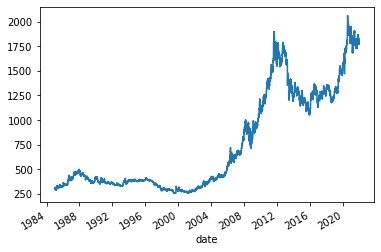

In [6]:
price[start:end].plot()
# plt.show()
# true_mret.plot()
# plt.show()
# true_yret.plot()

<AxesSubplot:>

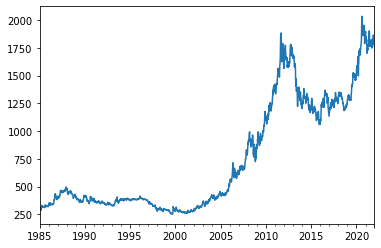

In [7]:
period_index = price.index.to_period('W')
weeklyprice = price.groupby(period_index).nth(-1)
weeklyprice.index = [idx.end_time.date() for idx in weeklyprice.index]
weeklyprice.index = pd.to_datetime(weeklyprice.index)
weeklyprice[start:end].plot()

In [8]:
ll = [34 + n*8 for n in range(0, 8)]
ll.sort()
sma_all = {'sma{}'.format(span): sma(weeklyprice.shift(), span) for span in ll}
sma_all = pd.DataFrame(sma_all).dropna()
sma_all

sma34        sma42      sma50        sma58        sma66  \
1981-09-20   468.073529   490.898810   514.7850   534.016379   545.928788   
1981-09-27   464.955882   486.708333   510.5150   530.861207   543.483333   
1981-10-04   463.308824   482.744048   505.8200   527.861207   541.180303   
1981-10-11   461.382353   479.702381   501.1100   524.340517   538.112121   
1981-10-18   460.264706   476.809524   497.5200   521.275862   534.930303   
...                 ...          ...        ...          ...          ...   
2022-01-16  1804.222353  1798.624286  1794.2240  1802.927931  1813.259545   
2022-01-23  1802.367059  1800.654048  1793.6466  1802.576379  1811.559394   
2022-01-30  1800.325882  1803.139762  1794.0790  1802.476552  1810.563485   
2022-02-06  1797.415882  1804.280952  1793.4304  1800.931207  1808.900455   
2022-02-13  1795.382059  1805.023333  1793.9340  1799.753103  1807.832879   

                  sma74        sma82        sma90  
1981-09-20   544.110135   545.492683   555.979444  
1981-09-27   543.183108   543.260976   555.257222  
1981-10-04   541.818243   540.986585   553.215556  
1981-10-11   540.770946   538.864634   551.126667  
1981-10-18   540.031081   538.017073   546.887778  
...                 ...          ...          ...  
2022-01-16  1825.745541  1828.181829  1818.383111  
2022-01-23  1824.035541  1829.088902  1819.380778  
2022-01-30  1822.600946  1829.852561  1820.871000  
2022-02-06  1820.256892  1830.050610  1821.875222  
2022-02-13  1818.568243  1830.162561  1822.614000  

[2109 rows x 8 columns]

In [9]:
sma_other = pd.DataFrame()
sma_other['average_sma'] = sma_all.mean(axis=1)
sma_other['min_sma'] = sma_all.min(axis=1)
sma_other['max_sma'] = sma_all.max(axis=1)
sma_other['ema5(average_sma)'] = ewma(sma_other['average_sma'], 5)
sma_other['ema25(average_sma)'] = ewma(sma_other['average_sma'], 25)
# sma_other = pd.DataFrame(sma_all)#[start:end]
sma_other.shape

(2109, 5)

In [ ]:
polt_sma_df = pd.concat([weeklyprice, sma_other], axis=1)
polt_sma_df[start:end].plot(figsize=(12,6))
polt_sma_df['1988':'2000'].plot(figsize=(12,6))
polt_sma_df['2001':'2005'].plot(figsize=(12,6))
polt_sma_df['2006':'2008'].plot(figsize=(12,6))
polt_sma_df['2009':'2011'].plot(figsize=(12,6))
polt_sma_df['2012':'2015'].plot(figsize=(12,6))
polt_sma_df['2016':'2021'].plot(figsize=(12,6))

In [11]:
pred_sma = pd.DataFrame()
pred_sma['average_sma_cross_ema25(average_sma)'] = sma_other['average_sma'] > sma_other['ema25(average_sma)']
pred_sma['average_sma_cross_ytd'] = sma_other['average_sma'] > sma_other['average_sma'].shift()
pred_sma['average_sma_cross_ema5(average_sma)'] = sma_other['average_sma'] > sma_other['ema5(average_sma)']
pred_sma['close_cross_average_sma'] = weeklyprice.shift().loc[sma_other.index] > sma_other['average_sma']
pred_sma['fast3sma_cross_average_sma'] = (sma_all['sma34'] > sma_other['average_sma']) & (sma_all['sma42'] > sma_other['average_sma']) & (sma_all['sma50'] > sma_other['average_sma'])
pred_sma['close_cross_min_sma'] = weeklyprice.shift().loc[sma_other.index] > sma_other['min_sma']
pred_sma['close_cross_max_sma'] = weeklyprice.shift().loc[sma_other.index] > sma_other['max_sma']
pred_sma.shape

(2109, 7)

In [12]:
import itertools
t = list(sma_all.columns)
c = list(itertools.combinations(t, 2))
pairs = list(set(c))
pairs.sort()
# pairs

In [13]:
def plot_with_flip(df, flip_df, sma_baseline, cont_min=4*6):
    maxvalue = df.max().max()
    minvalue = df.min().min()

    fig, ax = plt.subplots(figsize=(12,6))
    df.plot(ax=ax)
    previous_loc = None
    count_cont = 0
    for idx in flip_df.index:
        # print("==================================================")
        # print(idx, flip_df[idx], previous_loc)
        if flip_df[idx] or idx == flip_df.index[-1]:
            # plt.vlines(idx, minvalue, maxvalue)
        
            if previous_loc is None:
                previous_loc = (idx, sma_baseline[idx])
            else:
                current_loc = sma_baseline[idx]

                if count_cont >= cont_min:
                    if previous_loc[1] < current_loc:
                        facecolor ='green'
                    else:
                        facecolor ='red'
                    # print("        previous_loc: ", previous_loc)
                    # print("        current_loc: ", idx, current_loc)
                    # print("        facecolor: ", facecolor)
                    ax.axvspan(previous_loc[0], idx, alpha=0.5, color=facecolor)
                count_cont = 0
                previous_loc = (idx, current_loc)
        else:
            count_cont += 1
            if previous_loc is None:
                previous_loc = (idx, sma_baseline[idx])


    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.show()

In [14]:
flip_df = pd.DataFrame()
for a, b in pairs:
    x = sma_all[a]
    y = sma_all[b]
    diff = x - y
    diff_signal = (diff>0).astype(int)
    flip_df["{}_{}".format(a, b)] = (diff_signal != diff_signal.shift()).dropna()
flip_df

sma34_sma42  sma34_sma50  sma34_sma58  sma34_sma66  sma34_sma74  \
1981-09-20         True         True         True         True         True   
1981-09-27        False        False        False        False        False   
1981-10-04        False        False        False        False        False   
1981-10-11        False        False        False        False        False   
1981-10-18        False        False        False        False        False   
...                 ...          ...          ...          ...          ...   
2022-01-16        False        False        False        False        False   
2022-01-23        False        False         True        False        False   
2022-01-30         True        False        False        False        False   
2022-02-06        False        False        False        False        False   
2022-02-13        False        False        False        False        False   

            sma34_sma82  sma34_sma90  sma42_sma50  sma42_sma58  sma42_sma66  \
1981-09-20         True         True         True         True         True   
1981-09-27        False        False        False        False        False   
1981-10-04        False        False        False        False        False   
1981-10-11        False        False        False        False        False   
1981-10-18        False        False        False        False        False   
...                 ...          ...          ...          ...          ...   
2022-01-16        False        False        False        False        False   
2022-01-23        False        False        False        False        False   
2022-01-30        False        False        False         True        False   
2022-02-06        False        False        False        False        False   
2022-02-13        False        False        False        False        False   

            ...  sma58_sma66  sma58_sma74  sma58_sma82  sma58_sma90  \
1981-09-20  ...         True         True         True         True   
1981-09-27  ...        False        False        False        False   
1981-10-04  ...        False        False        False        False   
1981-10-11  ...        False        False        False        False   
1981-10-18  ...        False        False        False        False   
...         ...          ...          ...          ...          ...   
2022-01-16  ...        False        False        False        False   
2022-01-23  ...        False        False        False        False   
2022-01-30  ...        False        False        False        False   
2022-02-06  ...        False        False        False        False   
2022-02-13  ...        False        False        False        False   

            sma66_sma74  sma66_sma82  sma66_sma90  sma74_sma82  sma74_sma90  \
1981-09-20         True         True         True         True         True   
1981-09-27        False        False        False        False        False   
1981-10-04         True        False        False         True        False   
1981-10-11        False         True        False        False        False   
1981-10-18        False        False        False        False        False   
...                 ...          ...          ...          ...          ...   
2022-01-16        False        False        False         True        False   
2022-01-23        False        False        False        False        False   
2022-01-30        False        False        False        False        False   
2022-02-06        False        False        False        False         True   
2022-02-13        False        False        False        False        False   

            sma82_sma90  
1981-09-20         True  
1981-09-27        False  
1981-10-04        False  
1981-10-11        False  
1981-10-18        False  
...                 ...  
2022-01-16        False  
2022-01-23        False  
2022-01-30        False  
2022-02-06        False  
2022-02-13        False  


In [15]:
def drawdown_from_price(price):
    if isinstance(price, pd.Series):
        return _drawdown_from_price(price)
    elif isinstance(price, pd.DataFrame):
        return price.apply(_drawdown_from_price)
    else:
        raise non_pd_error

def _drawdown_from_price(price):
    shift_max = price.copy()
    _max = price.iloc[0]
    for i, j in price.items():
        #print('i', i)
        #print('j', j)
        _max = max(_max, j)
        shift_max[i] = _max
    return price / shift_max - 1

def return_to_price(ret, ini=100):
    price_0 = ret.iloc[:1] * 0 + ini
    price_0.index = [0]
    price = (1+ret).cumprod() * ini
    return pd.concat([price_0, price])

def drawdown_from_return(ret, ini=100):
    price = return_to_price(ret, ini)
    return drawdown_from_price(price).iloc[1:]

def avg_drawdown(ret):
    dd = drawdown_from_return(ret)
    return dd.mean()

In [16]:
def other_metric(ret):
    if isinstance(ret, pd.DataFrame):
        return ret.apply(other_metric).T
    
    pred_up = (ret!=0)*1
    
    highlight_ratio = pred_up.mean()
    flip_ratio = (pred_up - pred_up.shift()).abs().mean()
    
    idx_tmp = pred_up.index & true_up.index
    true_up_tmp = true_up.reindex(idx_tmp) * 1
    pred_up = pred_up.reindex(idx_tmp) * 1
    accu = accuracy_score(true_up_tmp, pred_up)
    prec = precision_score(true_up_tmp, pred_up)
    
    true_up_pct = true_ret.reindex(idx_tmp)
    true_up_pct_scaled = true_up_pct/true_up_pct.std() + 0.5
    
    mse = mean_squared_error(true_up_pct_scaled, pred_up)
    
    se = pd.Series(dtype='float64')
    
    se['highlight_ratio'] = highlight_ratio
    se['flip_ratio'] = flip_ratio
    se['accu'] = accu
    se['prec'] = prec
    se['mse'] = mse
    
    return se


def empy_metric(ret):
    if isinstance(ret, pd.DataFrame):
        return ret.apply(empy_metric).T
    total_return = lambda x: (1+x).prod()-1
    met_func = [total_return, empy.annual_return, empy.sharpe_ratio, empy.annual_volatility, 
                empy.max_drawdown, avg_drawdown]
    
    met_func_names = ['total_return', 'annual_return', 'sharpe_ratio', 'annual_volatility', 
                      'max_drawdown', 'avg_drawdown',]
    
    se = pd.Series([f(ret) for f in met_func], met_func_names)
    
    se['return/maxdd'] = -se.annual_return/se.max_drawdown
    se['return/avgdd'] = -se.annual_return/se.avg_drawdown
    
    return se

In [17]:
def print_all_result(ret_df, proba_df=None, topn=10, strategy_list_sel=None, base_case=None):
    
    display('{} to {}'.format(ret_df.index[0], ret_df.index[-1]))
    
    column_selected = ['annual_return', 'sharpe_ratio', 'max_drawdown', 'avg_drawdown', 'return/avgdd',]
    empy_metric_tmp = empy_metric(ret_df).sort_values('sharpe_ratio')
    if strategy_list_sel is None:

        strategy_list_sel = list(empy_metric_tmp.index)

        strategy_list_sel = strategy_list_sel[-topn:]

    if 'buy_and_hold' in strategy_list_sel:
        strategy_list_sel = [x for x in strategy_list_sel if x !='buy_and_hold']
    
    base_list = ['buy_and_hold']
    if base_case is not None:
        for bc in base_case:
            if bc == 'buy_and_hold':
                continue
            else:
                if bc not in strategy_list_sel:
                    base_list.append(bc)
    strategy_list_sel = base_list+strategy_list_sel
    
    other_metric_tmp = other_metric(ret_df)
    
    display(other_metric_tmp.loc[strategy_list_sel[1:]].iloc[:,:5])
    display(empy_metric_tmp.loc[strategy_list_sel][column_selected])
    
    fig, ax = plt.subplots(figsize=(20,15))
    
    cm = plt.get_cmap('gist_rainbow')
    NUM_COLORS = ret_df[strategy_list_sel].shape[1]
    ax.set_prop_cycle(color=[cm(1.*i/NUM_COLORS) for i in range(NUM_COLORS)])


    (1+ret_df[strategy_list_sel]).cumprod().plot(ax=ax)
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    ax.set_yscale("log")
    plt.show()
    
#     cvals  = [0, 0.5, 1]
#     colors = ["red", 'white', "lawngreen"]
#     cmap = LinearSegmentedColormap.from_list("", colors)
#     norm=plt.Normalize(min(cvals),max(cvals))
#     tuples = list(zip(map(norm,cvals), colors))
#     cmap = LinearSegmentedColormap.from_list("", tuples)
#     sm = plt.cm.ScalarMappable(cmap=cmap)#, norm=norm
#     sm.set_array([])

    
    if proba_df is None:
        return strategy_list_sel

    alpha = 1
    dot_size = 20
    
    base_cumret = (1+ret_df['buy_and_hold']).cumprod().apply(math.log)
    base_cumret.name = 'buy_and_hold'
    
    for case in strategy_list_sel:
        if case not in proba_df.columns:
            continue
        print("====================================", case)
#         try:
        if True:
            df_temp = pd.concat([ret_df[case], proba_df[case]],1,keys=['return','pred prob']).dropna()

    #         df_temp['log return'] = (1+df_temp['return']).apply(math.log)
    #         df_temp['cumulative return'] = (1+df_temp['return']).cumprod()-1
            df_temp['log cumulative return'] = (1+df_temp['return']).cumprod().apply(math.log)

            z_ret = ret_df[case]/ret_df[case].std()
            z_prod = (proba_df[case]-0.5)/proba_df[case].std()
            df_temp['score'] = 3-abs(z_ret-z_prod)

            df_temp = df_temp.reset_index()
            df_temp['date'] = pd.to_datetime(df_temp['date'])
            
#             display(df_temp)
            
            plot_hue = 'pred prob'
        
            cvals  = [0,0.5,1]
            colors = ["red","white","lawngreen"]
            norm = plt.Normalize(min(cvals),max(cvals))
            tuples = list(zip(map(norm,cvals), colors))
            cmap_prob = LinearSegmentedColormap.from_list("", tuples)
            sm_prob = plt.cm.ScalarMappable(cmap=cmap_prob, norm=norm)
            sm_prob.set_array([])
            
            fig, ax = plt.subplots(figsize=(20,15))
            ax = sns.scatterplot(data=df_temp, x='date', y='log cumulative return', hue=plot_hue,
                                 #hue='score', alpha=0.5, palette=cmap, s=20)
                                 alpha=0.5, palette=cmap_prob, s=dot_size
#                                  cmap=cmap_prob
                                )
            base_cumret.plot(ax=ax)

            ax.set_xlim([df_temp['date'].iloc[0], df_temp['date'].iloc[-1]])
            ax.get_legend()#.remove()
#             ax.set_yscale("log")
            ax.figure.colorbar(sm_prob)
            ax.set_title("{} {}".format(case, plot_hue))
            plt.show()
            
            fig, ax = plt.subplots(figsize=(12,10))
            proba_df.loc[ret_df.index, case].plot(kind='bar', ax=ax, legend=False)
#             ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
            ax.set_title(case + ' proba')
            plt.show()
#         except Exception as e:
#             print(e)
#             continue
    
    
    return strategy_list_sel
    

In [28]:
polt_sma_df = pd.concat([weeklyprice, sma_all, sma_other], axis=1)
cross_any = flip_df.any(axis=1)

In [ ]:
cont_min = 48
# cc = pd.concat([cross_any, cross_any != cross_any.shift()], axis=1)
# cc_flip = cc.all(axis=1)

plot_with_flip(polt_sma_df[start:end], cross_any[start:end], sma_other['average_sma'], cont_min)
plot_with_flip(polt_sma_df['1988':'2000'], cross_any['1988':'2000'], sma_other['average_sma'], cont_min)
plot_with_flip(polt_sma_df['2001':'2005'], cross_any['2001':'2005'], sma_other['average_sma'], cont_min)
plot_with_flip(polt_sma_df['2006':'2008'], cross_any['2006':'2008'], sma_other['average_sma'], cont_min)
plot_with_flip(polt_sma_df['2009':'2011'], cross_any['2009':'2011'], sma_other['average_sma'], cont_min)
plot_with_flip(polt_sma_df['2012':'2015'], cross_any['2012':'2015'], sma_other['average_sma'], cont_min)
plot_with_flip(polt_sma_df['2016':'2021'], cross_any['2016':'2021'], sma_other['average_sma'], cont_min)


for i in range(int(start), int(end)):
    plot_with_flip(polt_sma_df[str(i)], cross_any[str(i)], sma_other['average_sma'], cont_min)

In [20]:
weekly_ret = weeklyprice.pct_change()
weekly_up = (weekly_ret >= 0).astype(int)

In [21]:
lookback = 1
rollback_cross_D1_5 = cross_any.rolling(lookback).apply(lambda x: not x.any())
rollback_cross_D1_5.name = 'phase15_lookback{}W'.format(lookback)
# rollback_cross_D1_5

In [30]:
sma_trend = sma_other['average_sma'].pct_change(lookback)
sma_trend = (sma_trend>=0)#.all(axis=1)
sma_trend

1981-09-20    False
1981-09-27    False
1981-10-04    False
1981-10-11    False
1981-10-18    False
              ...  
2022-01-16    False
2022-01-23    False
2022-01-30     True
2022-02-06    False
2022-02-13    False
Name: average_sma, Length: 2109, dtype: bool

In [22]:
"""sma_trend = sma_all.pct_change(lookback)
sma_trend = (sma_trend>=0).all(axis=1)"""
#.apply(lambda x: not x.any())
# sma_trend['2008-08':'2008-12']

In [ ]:
sma_trend['2012']

In [33]:
# rollback_cross_D1_5
filter_D1_5 = pd.Series(np.nan, index=rollback_cross_D1_5.index)
filter_D1_5.name = rollback_cross_D1_5.name
# cross_period = rollback_cross_D1_5.index[rollback_cross_D1_5!=1]
# filter_D1_5[cross_period] = np.nan

parallel_period = rollback_cross_D1_5.index[rollback_cross_D1_5==1]
parallel_sma_trend = sma_trend[parallel_period]
parallel_up_period = parallel_sma_trend.index[parallel_sma_trend==1]
parallel_down_period = parallel_sma_trend.index[parallel_sma_trend==0]

filter_D1_5[parallel_up_period] = 5
filter_D1_5[parallel_down_period] = 1

# filter_D1_5['2008-08':'2008-12']
# pd.Series(index=parallel_period)['2008-08':'2008-12']

In [34]:
filter_D1_5['2012']

2012-01-01    5.0
2012-01-08    5.0
2012-01-15    5.0
2012-01-22    5.0
2012-01-29    5.0
2012-02-05    5.0
2012-02-12    5.0
2012-02-19    5.0
2012-02-26    5.0
2012-03-04    5.0
2012-03-11    5.0
2012-03-18    5.0
2012-03-25    5.0
2012-04-01    5.0
2012-04-08    5.0
2012-04-15    5.0
2012-04-22    5.0
2012-04-29    5.0
2012-05-06    NaN
2012-05-13    5.0
2012-05-20    5.0
2012-05-27    5.0
2012-06-03    NaN
2012-06-10    5.0
2012-06-17    5.0
2012-06-24    NaN
2012-07-01    5.0
2012-07-08    NaN
2012-07-15    NaN
2012-07-22    5.0
2012-07-29    5.0
2012-08-05    NaN
2012-08-12    5.0
2012-08-19    NaN
2012-08-26    5.0
2012-09-02    NaN
2012-09-09    NaN
2012-09-16    NaN
2012-09-23    5.0
2012-09-30    NaN
2012-10-07    5.0
2012-10-14    NaN
2012-10-21    5.0
2012-10-28    5.0
2012-11-04    NaN
2012-11-11    NaN
2012-11-18    NaN
2012-11-25    5.0
2012-12-02    5.0
2012-12-09    NaN
2012-12-16    NaN
2012-12-23    NaN
2012-12-30    NaN
Name: phase15_lookback1W, dtype: float64

In [35]:
pred_sma = pred_sma.astype(int)
pred_sma_vote = pred_sma.mean(axis=1)
pred_sma_vote

1981-09-20    0.000000
1981-09-27    0.000000
1981-10-04    0.000000
1981-10-11    0.000000
1981-10-18    0.000000
                ...   
2022-01-16    0.285714
2022-01-23    0.428571
2022-01-30    0.714286
2022-02-06    0.142857
2022-02-13    0.285714
Length: 2109, dtype: float64

In [36]:
# true_ret_3stage = pd.cut(weekly_up, bins=[0, 0.3, 0.6, 1], right=True, labels=False).fillna(0)(weekly_up >= 0).astype(int)

bins=[0, 0.4, 0.6, 1]
# bins=[0, 0.3, 0.8, 1]

true_yret_roll_vote_pred = pd.DataFrame(index=weekly_up.index)
true_yret_roll_vote_proba = pd.DataFrame(index=weekly_up.index)

pred_sma = pred_sma.astype(int)
pred_sma_vote = pred_sma.mean(axis=1)
true_yret_roll_vote_proba['phase234_no-lookback_vote_otherSMA'] = pred_sma_vote
pp = pd.cut(pred_sma_vote, bins=bins, right=True, labels=False).fillna(0)
pp.name = 'phase234_no-lookback_vote_otherSMA'
true_yret_roll_vote_pred = pd.concat([true_yret_roll_vote_pred, pp], axis=1)

lookbacks = [3, 4, 5, 10, 12, 15, 24, 48]
for lookback in lookbacks:
    true_yret_rollN = pred_sma_vote.rolling(lookback).mean()
    true_yret_rollN.name = 'phase234_lookback{}W_vote_otherSMA'.format(lookback)
    true_yret_roll_vote_proba = pd.concat([true_yret_roll_vote_proba, true_yret_rollN], axis=1)

    pp = pd.cut(true_yret_rollN, bins=bins, right=True, labels=False).fillna(0)
    pp.name = 'phase234_lookback{}W_vote_otherSMA'.format(lookback)
    true_yret_roll_vote_pred = pd.concat([true_yret_roll_vote_pred, pp], axis=1)

true_yret_roll_vote_proba = true_yret_roll_vote_proba.shift().dropna()
true_yret_roll_vote_pred = true_yret_roll_vote_pred.shift().dropna()
true_yret_roll_vote_pred = true_yret_roll_vote_pred + 2

# true_yret_roll_vote_pred.index = pd.to_datetime(['{}-01-01'.format(i) for i in true_yret_roll_vote_pred.index])
# true_yret_roll_vote_proba.index = pd.to_datetime(['{}-01-01'.format(i) for i in true_yret_roll_vote_proba.index])
# true_yret_roll_vote_proba

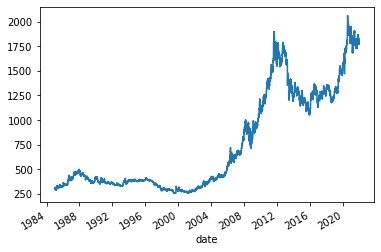

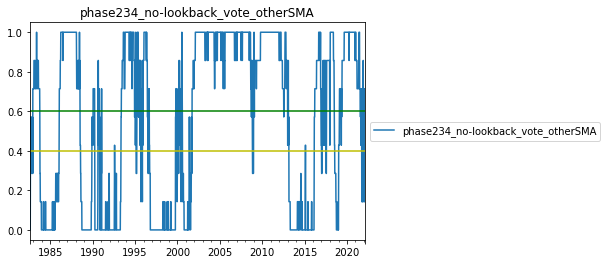

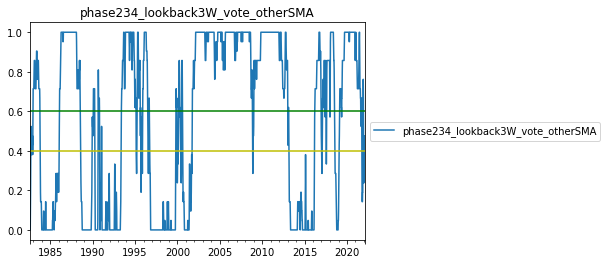

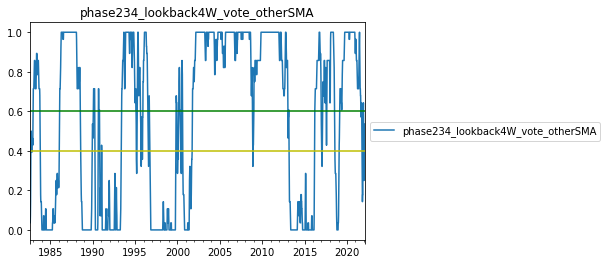

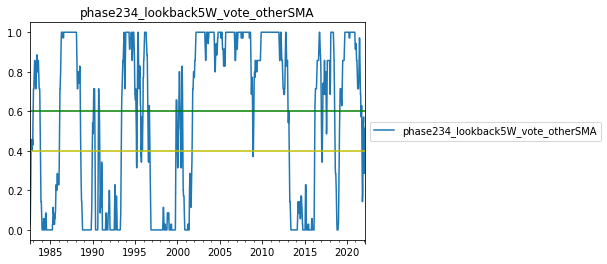

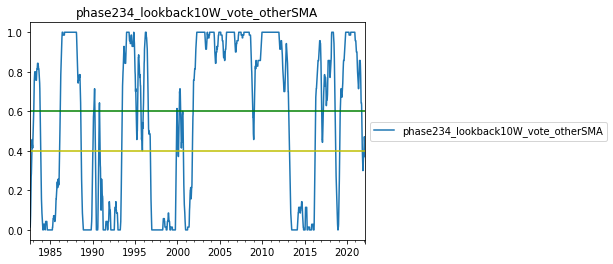

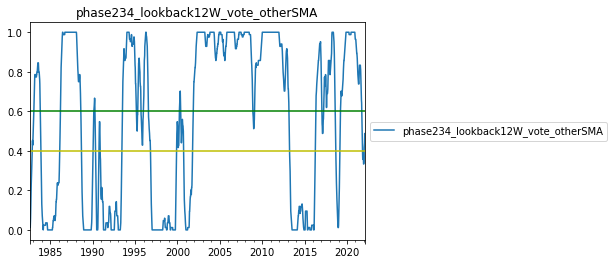

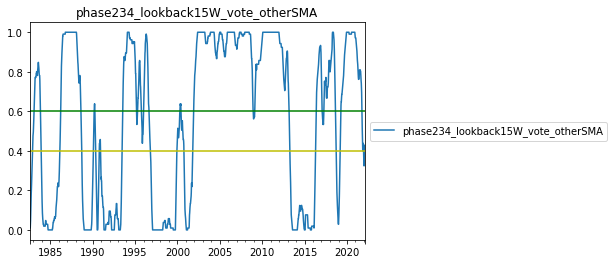

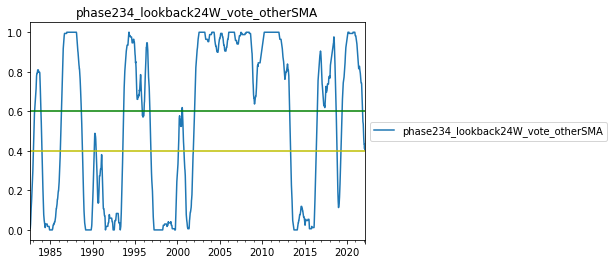

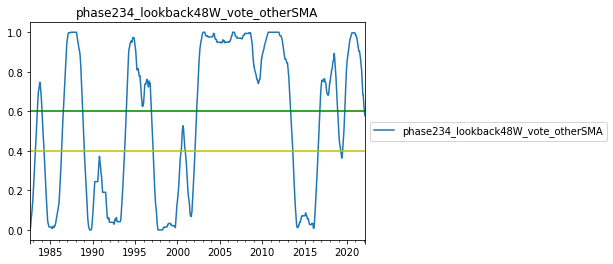

In [37]:
price[start:end].plot()
plt.show()

# bounds = pd.DataFrame([[0.5, 0.55]] * len(tt.index), index=tt.index, columns=['lower', 'upper'])
# true_yret_roll_vote_proba.plot().legend(loc='center left', bbox_to_anchor=(1, 0.5))
# plt.hlines(y = 0.5, xmin = true_yret_roll_vote_proba.index[0], xmax = true_yret_roll_vote_proba.index[-1], label ="lower", color='y')
# plt.hlines(y = 0.55, xmin = true_yret_roll_vote_proba.index[0], xmax = true_yret_roll_vote_proba.index[-1], label ="upper", color='g')
# plt.show()

for col in true_yret_roll_vote_proba.columns:
    tt = true_yret_roll_vote_proba[col]
    tt.plot(title=col).legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.hlines(y = bins[1], xmin = true_yret_roll_vote_proba.index[0], xmax = true_yret_roll_vote_proba.index[-1], label ="lower", color='y')
    plt.hlines(y = bins[2], xmin = true_yret_roll_vote_proba.index[0], xmax = true_yret_roll_vote_proba.index[-1], label ="upper", color='g')
    plt.show()

In [38]:
rollback_cross = pd.DataFrame()
for col in true_yret_roll_vote_pred.columns:
    tmp = pd.concat([true_yret_roll_vote_pred[col], filter_D1_5], axis=1)
    tmp = tmp.fillna(method='ffill', axis=1)
    rollback_cross["{}_{}".format(filter_D1_5.name, col)] = tmp.iloc[:, -1]
# rollback_cross

In [39]:
def plot_with_flip_5stages(df, rollback_cross):
    maxvalue = df.max().max()
    minvalue = df.min().min()

    facecolor_map = {
        1: 'red',
        2: 'yellow',
        3: 'c',
        4: 'g',
        5: 'lime'
    }

    
    count_cont = 0
    for case in rollback_cross.columns:
        # print("==================================================")
        # print(idx, flip_df[idx], previous_loc)
        stage_ser = rollback_cross[case]

        fig, ax = plt.subplots(figsize=(12,6))
        df.plot(ax=ax)

        previous_stage = None
        for idx in stage_ser.index:
            if previous_stage is None:
                previous_stage = stage_ser[idx]
                baseline_loc = idx
                continue

            current_stage = stage_ser[idx]
            if idx == stage_ser.index[-1]:
                facecolor = facecolor_map[current_stage]
                ax.axvspan(baseline_loc, idx, alpha=0.5, color=facecolor)
                continue

            if current_stage == previous_stage:
                continue
            else:
                facecolor = facecolor_map[previous_stage]
                ax.axvspan(baseline_loc, idx, alpha=0.5, color=facecolor)
                previous_stage = current_stage
                baseline_loc = idx
        ax.set_title(case)
        ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
        plt.show()

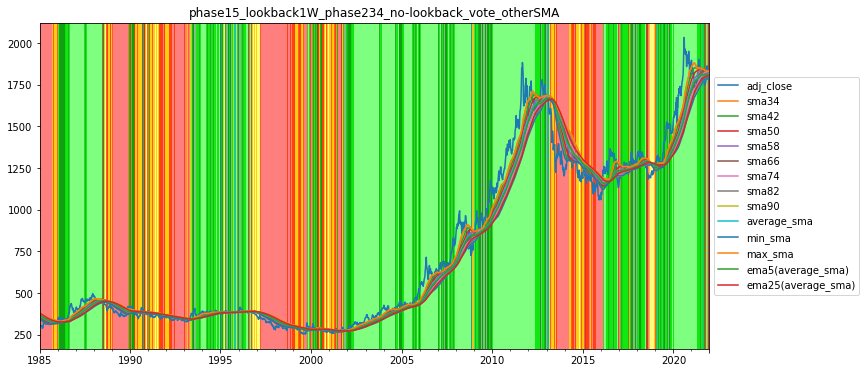

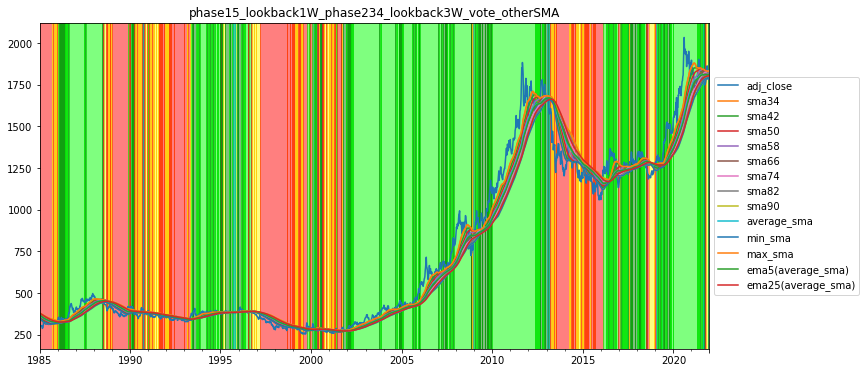

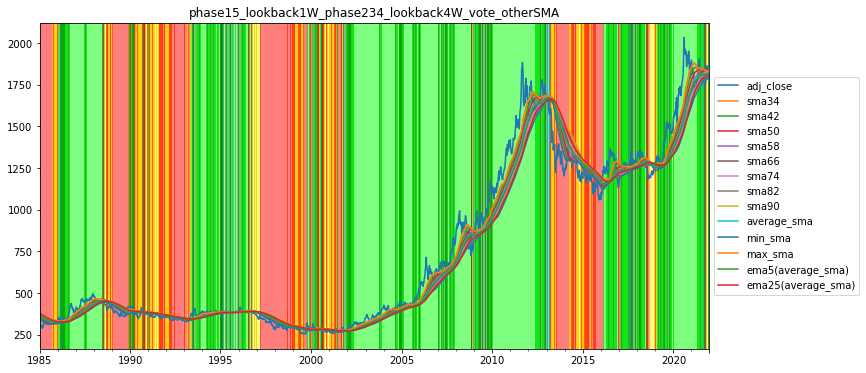

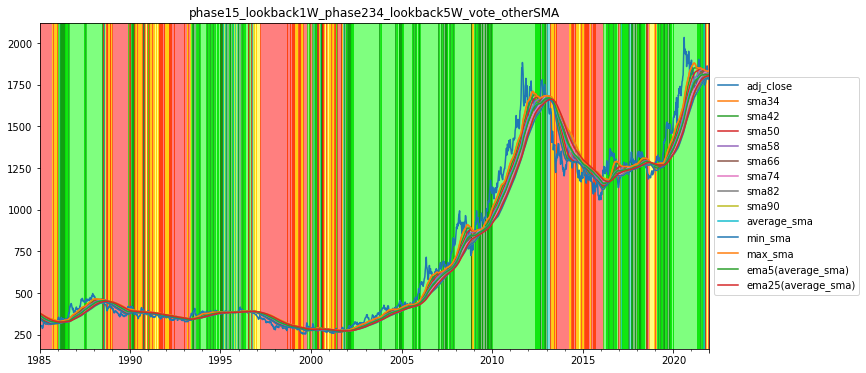

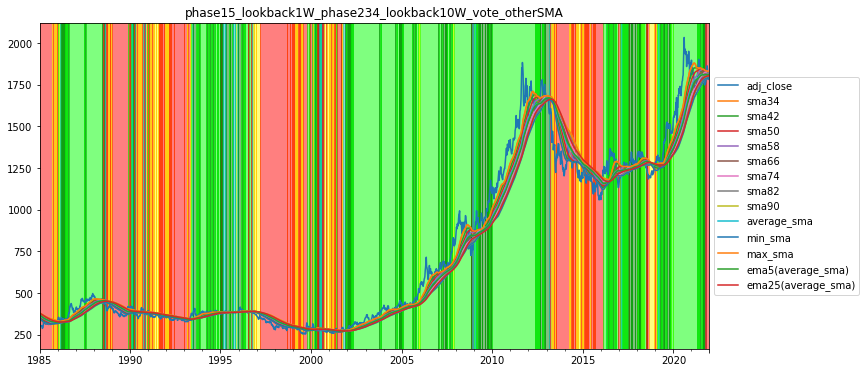

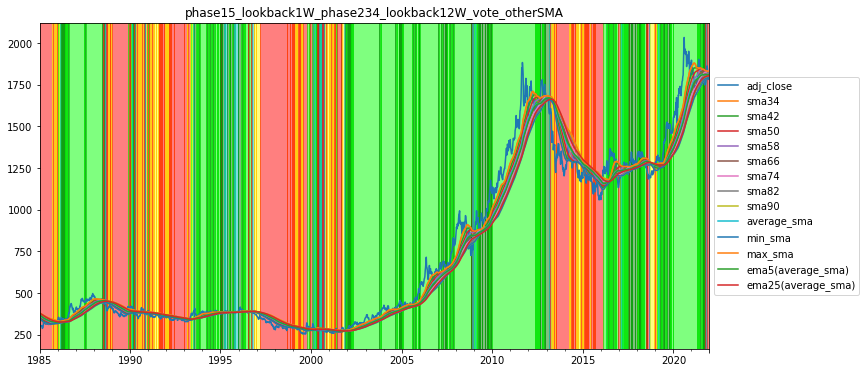

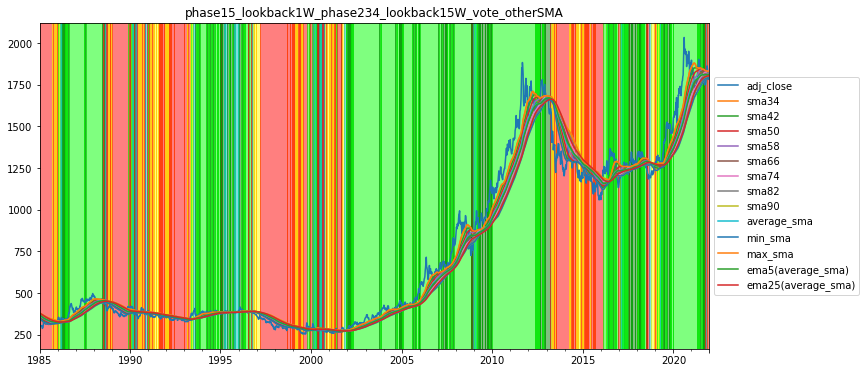

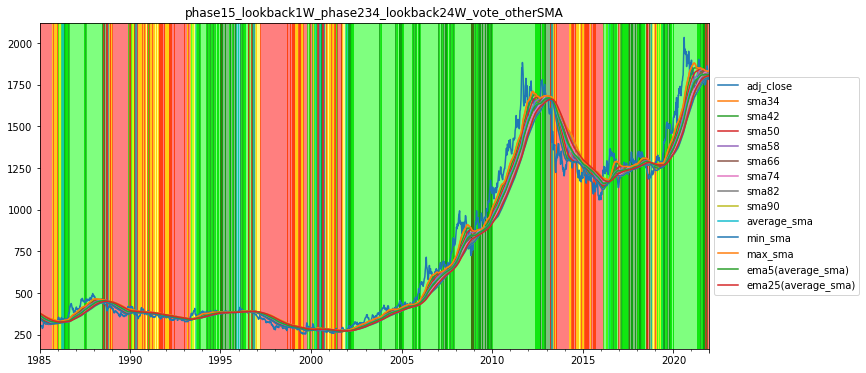

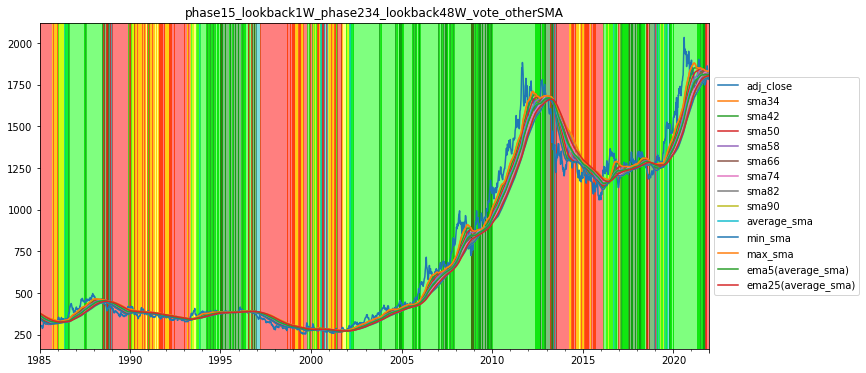

In [40]:
plot_with_flip_5stages(polt_sma_df[start:end], rollback_cross[start:end])

In [95]:
"""plot_with_flip_5stages(polt_sma_df[start:end], rollback_cross[start:end])
plot_with_flip_5stages(polt_sma_df['1988':'2000'], rollback_cross['1988':'2000'])
plot_with_flip_5stages(polt_sma_df['2001':'2005'], rollback_cross['2001':'2005'])
plot_with_flip_5stages(polt_sma_df['2006':'2008'], rollback_cross['2006':'2008'])
plot_with_flip_5stages(polt_sma_df['2009':'2011'], rollback_cross['2009':'2011'])
plot_with_flip_5stages(polt_sma_df['2012':'2015'], rollback_cross['2012':'2015'])
plot_with_flip_5stages(polt_sma_df['2016':'2021'], rollback_cross['2016':'2021'])


for i in range(int(start), int(end)):
    plot_with_flip_5stages(polt_sma_df[str(i)], rollback_cross[str(i)])"""

"plot_with_flip_5stages(polt_sma_df[start:end], rollback_cross[start:end])\nplot_with_flip_5stages(polt_sma_df['1988':'2000'], rollback_cross['1988':'2000'])\nplot_with_flip_5stages(polt_sma_df['2001':'2005'], rollback_cross['2001':'2005'])\nplot_with_flip_5stages(polt_sma_df['2006':'2008'], rollback_cross['2006':'2008'])\nplot_with_flip_5stages(polt_sma_df['2009':'2011'], rollback_cross['2009':'2011'])\nplot_with_flip_5stages(polt_sma_df['2012':'2015'], rollback_cross['2012':'2015'])\nplot_with_flip_5stages(polt_sma_df['2016':'2021'], rollback_cross['2016':'2021'])\n\n\nfor i in range(int(start), int(end)):\n    plot_with_flip_5stages(polt_sma_df[str(i)], rollback_cross[str(i)])"

In [41]:
preds = pd.DataFrame(1, columns=['buy_and_hold'], index=true_ret.index)
preds = pd.concat([preds, rollback_cross], axis=1)
preds = preds.fillna(method='ffill')
preds = preds.loc[true_ret.index, :]
# preds = preds['1994': end]
# preds.shape
preds.shape

(10921, 10)

In [42]:
buy_preds = pd.DataFrame(1, columns=['buy_and_hold'], index=true_ret.index)
for case in rollback_cross.columns:
    for i in range(2, 6):
        buy_preds["{}_buy>={}".format(case, i)] = (preds[case] >= i).astype(int)
buy_preds = buy_preds[start:end]
buy_preds.shape

(9612, 37)

In [43]:
ret_sma_cross = buy_preds.multiply(true_ret[start:end], 0)
ret_sma_cross.shape

(9612, 37)

'1985-01-02 00:00:00 to 2021-12-31 00:00:00'

highlight_ratio  \
phase15_lookback1W_phase234_no-lookback_vote_ot...         0.729089   
phase15_lookback1W_phase234_lookback15W_vote_ot...         0.729089   
phase15_lookback1W_phase234_lookback3W_vote_oth...         0.729089   
phase15_lookback1W_phase234_lookback48W_vote_ot...         0.729089   
phase15_lookback1W_phase234_lookback10W_vote_ot...         0.729089   
phase15_lookback1W_phase234_lookback4W_vote_oth...         0.729089   
phase15_lookback1W_phase234_lookback12W_vote_ot...         0.729089   
phase15_lookback1W_phase234_lookback24W_vote_ot...         0.729089   
phase15_lookback1W_phase234_lookback5W_vote_oth...         0.729089   
phase15_lookback1W_phase234_no-lookback_vote_ot...         0.611943   
phase15_lookback1W_phase234_lookback48W_vote_ot...         0.584166   
phase15_lookback1W_phase234_no-lookback_vote_ot...         0.588327   
phase15_lookback1W_phase234_lookback5W_vote_oth...         0.613296   
phase15_lookback1W_phase234_lookback15W_vote_ot...         0.626092   
phase15_lookback1W_phase234_lookback4W_vote_oth...         0.613296   
phase15_lookback1W_phase234_lookback24W_vote_ot...         0.622451   
phase15_lookback1W_phase234_lookback48W_vote_ot...         0.620578   
phase15_lookback1W_phase234_lookback12W_vote_ot...         0.622867   
phase15_lookback1W_phase234_lookback3W_vote_oth...         0.613296   
phase15_lookback1W_phase234_lookback24W_vote_ot...         0.434041   
phase15_lookback1W_phase234_lookback12W_vote_ot...         0.434041   
phase15_lookback1W_phase234_lookback15W_vote_ot...         0.434041   
phase15_lookback1W_phase234_lookback48W_vote_ot...         0.434041   
phase15_lookback1W_phase234_lookback10W_vote_ot...         0.434041   
phase15_lookback1W_phase234_lookback5W_vote_oth...         0.434041   
phase15_lookback1W_phase234_lookback4W_vote_oth...         0.434041   
phase15_lookback1W_phase234_lookback3W_vote_oth...         0.434041   
phase15_lookback1W_phase234_no-lookback_vote_ot...         0.434041   
phase15_lookback1W_phase234_lookback12W_vote_ot...         0.580316   
phase15_lookback1W_phase234_lookback10W_vote_ot...         0.613608   
phase15_lookback1W_phase234_lookback10W_vote_ot...         0.576363   
phase15_lookback1W_phase234_lookback15W_vote_ot...         0.576987   
phase15_lookback1W_phase234_lookback3W_vote_oth...         0.590408   
phase15_lookback1W_phase234_lookback4W_vote_oth...         0.590824   
phase15_lookback1W_phase234_lookback5W_vote_oth...         0.584582   
phase15_lookback1W_phase234_lookback24W_vote_ot...         0.580316   

                                                    flip_ratio      accu  \
phase15_lookback1W_phase234_no-lookback_vote_ot...    0.043284  0.511548   
phase15_lookback1W_phase234_lookback15W_vote_ot...    0.043284  0.511548   
phase15_lookback1W_phase234_lookback3W_vote_oth...    0.043284  0.511548   
phase15_lookback1W_phase234_lookback48W_vote_ot...    0.043284  0.511548   
phase15_lookback1W_phase234_lookback10W_vote_ot...    0.043284  0.511548   
phase15_lookback1W_phase234_lookback4W_vote_oth...    0.043284  0.511548   
phase15_lookback1W_phase234_lookback12W_vote_ot...    0.043284  0.511548   
phase15_lookback1W_phase234_lookback24W_vote_ot...    0.043284  0.511548   
phase15_lookback1W_phase234_lookback5W_vote_oth...    0.043284  0.511548   
phase15_lookback1W_phase234_no-lookback_vote_ot...    0.019353  0.515710   
phase15_lookback1W_phase234_lookback48W_vote_ot...    0.026636  0.516854   
phase15_lookback1W_phase234_no-lookback_vote_ot...    0.020185  0.514981   
phase15_lookback1W_phase234_lookback5W_vote_oth...    0.020185  0.516646   
phase15_lookback1W_phase234_lookback15W_vote_ot...    0.022890  0.515710   
phase15_lookback1W_phase234_lookback4W_vote_oth...    0.019561  0.515814   
phase15_lookback1W_phase234_lookback24W_vote_ot...    0.024347  0.516230   
phase15_lookback1W_phase234_lookback48W_vote_ot...    0.028509  0.516646   
phase15_lookback1W_phase234_lookback12W_vote_ot...    0.

annual_return  \
buy_and_hold                                             0.047776   
phase15_lookback1W_phase234_no-lookback_vote_ot...       0.035664   
phase15_lookback1W_phase234_lookback15W_vote_ot...       0.035664   
phase15_lookback1W_phase234_lookback3W_vote_oth...       0.035664   
phase15_lookback1W_phase234_lookback48W_vote_ot...       0.035664   
phase15_lookback1W_phase234_lookback10W_vote_ot...       0.035664   
phase15_lookback1W_phase234_lookback4W_vote_oth...       0.035664   
phase15_lookback1W_phase234_lookback12W_vote_ot...       0.035664   
phase15_lookback1W_phase234_lookback24W_vote_ot...       0.035664   
phase15_lookback1W_phase234_lookback5W_vote_oth...       0.035664   
phase15_lookback1W_phase234_no-lookback_vote_ot...       0.041573   
phase15_lookback1W_phase234_lookback48W_vote_ot...       0.043769   
phase15_lookback1W_phase234_no-lookback_vote_ot...       0.044478   
phase15_lookback1W_phase234_lookback5W_vote_oth...       0.045060   
phase15_lookback1W_phase234_lookback15W_vote_ot...       0.045275   
phase15_lookback1W_phase234_lookback4W_vote_oth...       0.045490   
phase15_lookback1W_phase234_lookback24W_vote_ot...       0.045844   
phase15_lookback1W_phase234_lookback48W_vote_ot...       0.045742   
phase15_lookback1W_phase234_lookback12W_vote_ot...       0.045944   
phase15_lookback1W_phase234_lookback3W_vote_oth...       0.045917   
phase15_lookback1W_phase234_lookback24W_vote_ot...       0.042475   
phase15_lookback1W_phase234_lookback12W_vote_ot...       0.042475   
phase15_lookback1W_phase234_lookback15W_vote_ot...       0.042475   
phase15_lookback1W_phase234_lookback48W_vote_ot...       0.042475   
phase15_lookback1W_phase234_lookback10W_vote_ot...       0.042475   
phase15_lookback1W_phase234_lookback5W_vote_oth...       0.042475   
phase15_lookback1W_phase234_lookback4W_vote_oth...       0.042475   
phase15_lookback1W_phase234_lookback3W_vote_oth...       0.042475   
phase15_lookback1W_phase234_no-lookback_vote_ot...       0.042475   
phase15_lookback1W_phase234_lookback12W_vote_ot...       0.045952   
phase15_lookback1W_phase234_lookback10W_vote_ot...       0.047080   
phase15_lookback1W_phase234_lookback10W_vote_ot...       0.046177   
phase15_lookback1W_phase234_lookback15W_vote_ot...       0.047066   
phase15_lookback1W_phase234_lookback3W_vote_oth...       0.049129   
phase15_lookback1W_phase234_lookback4W_vote_oth...       0.049673   
phase15_lookback1W_phase234_lookback5W_vote_oth...       0.050595   
phase15_lookback1W_phase234_lookback24W_vote_ot...       0.050559   

                                                    sharpe_ratio  \
buy_and_hold                                            0.378081   
phase15_lookback1W_phase234_no-lookback_vote_ot...      0.325568   
phase15_lookback1W_phase234_lookback15W_vote_ot...      0.325568   
phase15_lookback1W_phase234_lookback3W_vote_oth...      0.325568   
phase15_lookback1W_phase234_lookback48W_vote_ot...      0.325568   
phase15_lookback1W_phase234_lookback10W_vote_ot...      0.325568   
phase15_lookback1W_phase234_lookback4W_vote_oth...      0.325568   
phase15_lookback1W_phase234_lookback12W_vote_ot...      0.325568   
phase15_lookback1W_phase234_lookback24W_vote_ot...      0.325568   
phase15_lookback1W_phase234_lookback5W_vote_oth...      0.325568   
phase15_lookback1W_phase234_no-lookback_vote_ot...      0.380260   
phase15_lookback1W_phase234_lookback48W_vote_ot...      0.404645   
phase15_lookback1W_phase234_no-lookback_vote_ot...      0.406934   
phase15_lookback1W_phase234_lookback5W_vote_oth...      0.409035   
phase15_lookback1W_phase234_lookback15W_vote_ot...      0.409787   
phase15_lookback1W_phase234_lookback4W_vote_oth...      0.411980   
phase15_lookback1W_phase234_lookback24W_vote_ot...      0.413828   
phase15_lookback1W_phase234_lookback48W_vote_ot...      0.414052   
phase15_lookback1W_phase234_lookback12W_vote_ot...      0.414231   
phase15_lookback1W_phase234_lookback3W_vote_oth...      0.415167   
p

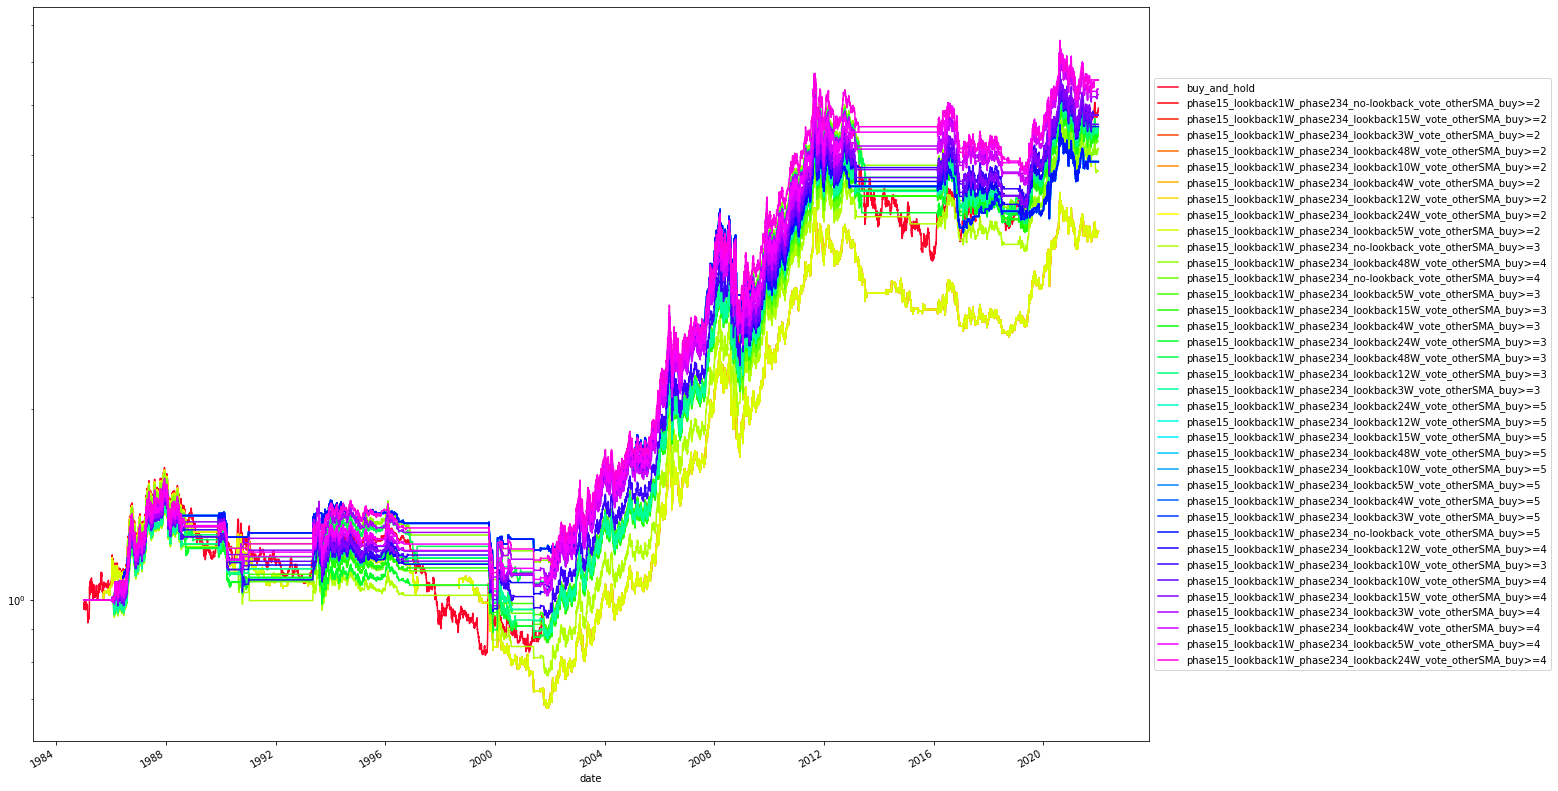

In [44]:
strategy_list_sel = print_all_result(ret_sma_cross, topn=len(ret_sma_cross.columns))

'1985-01-02 00:00:00 to 2021-12-31 00:00:00'

highlight_ratio  \
phase15_lookback1W_phase234_lookback3W_vote_oth...         0.434041   
phase15_lookback1W_phase234_no-lookback_vote_ot...         0.434041   
phase15_lookback1W_phase234_lookback12W_vote_ot...         0.580316   
phase15_lookback1W_phase234_lookback10W_vote_ot...         0.613608   
phase15_lookback1W_phase234_lookback10W_vote_ot...         0.576363   
phase15_lookback1W_phase234_lookback15W_vote_ot...         0.576987   
phase15_lookback1W_phase234_lookback3W_vote_oth...         0.590408   
phase15_lookback1W_phase234_lookback4W_vote_oth...         0.590824   
phase15_lookback1W_phase234_lookback5W_vote_oth...         0.584582   
phase15_lookback1W_phase234_lookback24W_vote_ot...         0.580316   

                                                    flip_ratio      accu  \
phase15_lookback1W_phase234_lookback3W_vote_oth...    0.042659  0.508427   
phase15_lookback1W_phase234_no-lookback_vote_ot...    0.042659  0.508427   
phase15_lookback1W_phase234_lookback12W_vote_ot...    0.021226  0.516750   
phase15_lookback1W_phase234_lookback10W_vote_ot...    0.023515  0.515501   
phase15_lookback1W_phase234_lookback10W_vote_ot...    0.023307  0.516542   
phase15_lookback1W_phase234_lookback15W_vote_ot...    0.023307  0.516958   
phase15_lookback1W_phase234_lookback3W_vote_oth...    0.018937  0.516230   
phase15_lookback1W_phase234_lookback4W_vote_oth...    0.019977  0.517062   
phase15_lookback1W_phase234_lookback5W_vote_oth...    0.019353  0.516646   
phase15_lookback1W_phase234_lookback24W_vote_ot...    0.023099  0.518623   

                                                        prec       mse  
phase15_lookback1W_phase234_lookback3W_vote_oth...  0.529243  1.235253  
phase15_lookback1W_phase234_no-lookback_vote_ot...  0.529243  1.235253  
phase15_lookback1W_phase234_lookback12W_vote_ot...  0.529043  1.231507  
phase15_lookback1W_phase234_lookback10W_vote_ot...  0.526450  1.230370  
phase15_lookback1W_phase234_lookback10W_vote_ot...  0.529061  1.231374  
phase15_lookback1W_phase234_lookback15W_vote_ot...  0.529391  1.230607  
phase15_lookback1W_phase234_lookback3W_vote_oth...  0.528106  1.228912  
phase15_lookback1W_phase234_lookback4W_vote_oth...  0.528790  1.228434  
phase15_lookback1W_phase234_lookback5W_vote_oth...  0.528742  1.227790  
phase15_lookback1W_phase234_lookback24W_vote_ot...  0.530656  1.227915

annual_return  \
buy_and_hold                                             0.047776   
phase15_lookback1W_phase234_lookback3W_vote_oth...       0.042475   
phase15_lookback1W_phase234_no-lookback_vote_ot...       0.042475   
phase15_lookback1W_phase234_lookback12W_vote_ot...       0.045952   
phase15_lookback1W_phase234_lookback10W_vote_ot...       0.047080   
phase15_lookback1W_phase234_lookback10W_vote_ot...       0.046177   
phase15_lookback1W_phase234_lookback15W_vote_ot...       0.047066   
phase15_lookback1W_phase234_lookback3W_vote_oth...       0.049129   
phase15_lookback1W_phase234_lookback4W_vote_oth...       0.049673   
phase15_lookback1W_phase234_lookback5W_vote_oth...       0.050595   
phase15_lookback1W_phase234_lookback24W_vote_ot...       0.050559   

                                                    sharpe_ratio  \
buy_and_hold                                            0.378081   
phase15_lookback1W_phase234_lookback3W_vote_oth...      0.421225   
phase15_lookback1W_phase234_no-lookback_vote_ot...      0.421225   
phase15_lookback1W_phase234_lookback12W_vote_ot...      0.421937   
phase15_lookback1W_phase234_lookback10W_vote_ot...      0.424417   
phase15_lookback1W_phase234_lookback10W_vote_ot...      0.424628   
phase15_lookback1W_phase234_lookback15W_vote_ot...      0.429580   
phase15_lookback1W_phase234_lookback3W_vote_oth...      0.442744   
phase15_lookback1W_phase234_lookback4W_vote_oth...      0.445483   
phase15_lookback1W_phase234_lookback5W_vote_oth...      0.454076   
phase15_lookback1W_phase234_lookback24W_vote_ot...      0.456290   

                                                    max_drawdown  \
buy_and_hold                                           -0.493126   
phase15_lookback1W_phase234_lookback3W_vote_oth...     -0.321226   
phase15_lookback1W_phase234_no-lookback_vote_ot...     -0.321226   
phase15_lookback1W_phase234_lookback12W_vote_ot...     -0.345339   
phase15_lookback1W_phase234_lookback10W_vote_ot...     -0.378730   
phase15_lookback1W_phase234_lookback10W_vote_ot...     -0.343915   
phase15_lookback1W_phase234_lookback15W_vote_ot...     -0.372395   
phase15_lookback1W_phase234_lookback3W_vote_oth...     -0.326059   
phase15_lookback1W_phase234_lookback4W_vote_oth...     -0.331551   
phase15_lookback1W_phase234_lookback5W_vote_oth...     -0.326059   
phase15_lookback1W_phase234_lookback24W_vote_ot...     -0.325429   

                                                    avg_drawdown  return/avgdd  
buy_and_hold                                           -0.224901      0.212431  
phase15_lookback1W_phase234_lookback3W_vote_oth...     -0.132987      0.319395  
phase15_lookback1W_phase234_no-lookback_vote_ot...     -0.132987      0.319395  
phase15_lookback1W_phase234_lookback12W_vote_ot...     -0.153502      0.299361  
phase15_lookback1W_phase234_lookback10W_vote_ot...     -0.163037      0.288768  
phase15_lookback1W_phase234_lookback10W_vote_ot...     -0.144170      0.320299  
phase15_lookback1W_phase234_lookback15W_vote_ot...     -0.159894      0.294360  
phase15_lookback1W_phase234_lookback3W_vote_oth...     -0.125376      0.391850  
phase15_lookback1W_phase234_lookback4W_vote_oth...     -0.141761      0.350402  
phase15_lookback1W_phase234_lookback5W_vote_oth...     -0.133120      0.380071  
phase15_lookback1W_phase234_lookback24W_vote_ot...     -0.138743      0.364405

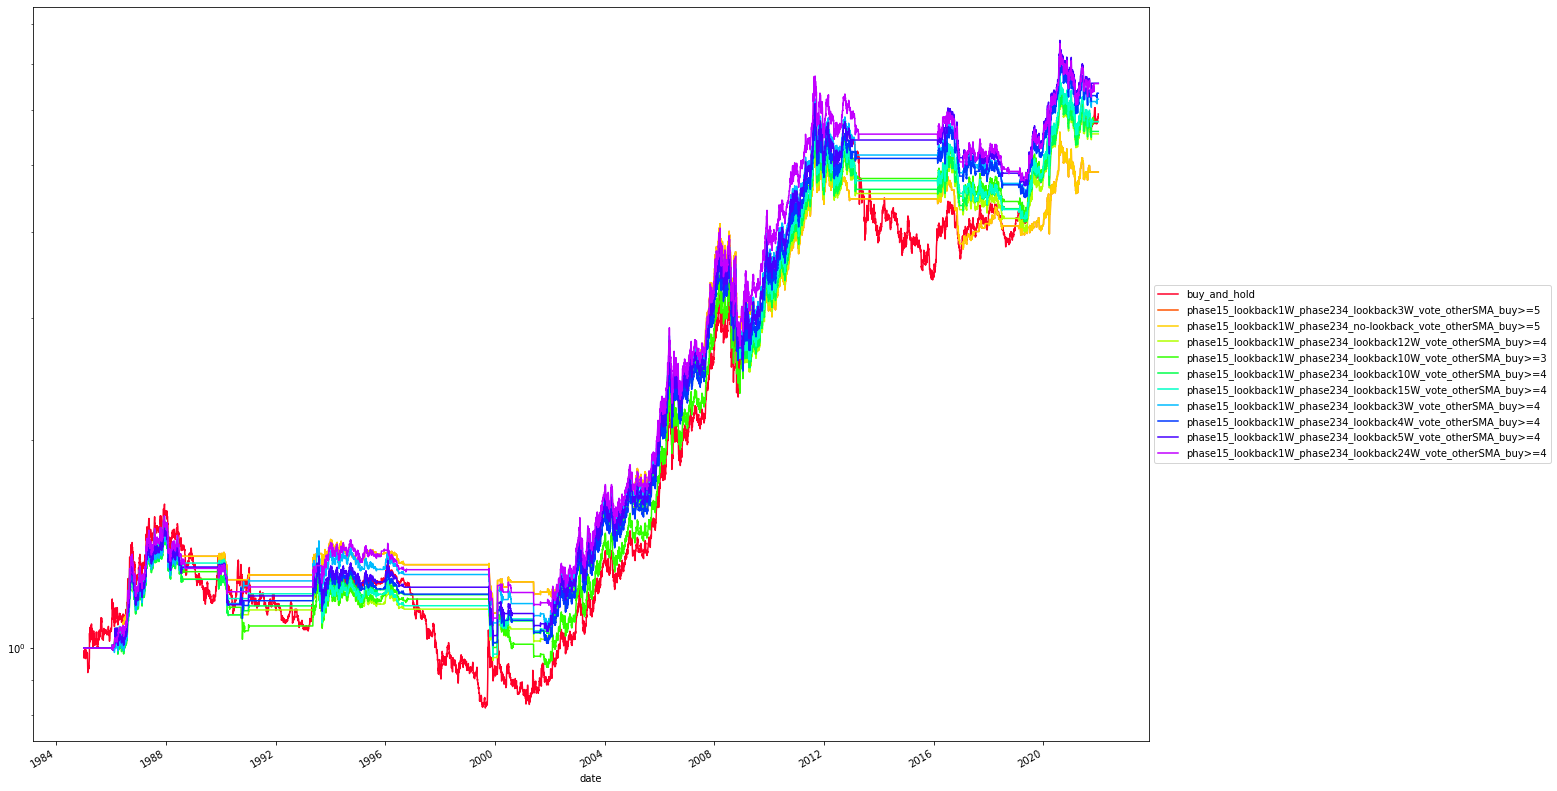

'1988-01-04 00:00:00 to 2000-12-29 00:00:00'

highlight_ratio  \
phase15_lookback1W_phase234_lookback3W_vote_oth...         0.185854   
phase15_lookback1W_phase234_no-lookback_vote_ot...         0.185854   
phase15_lookback1W_phase234_lookback12W_vote_ot...         0.297721   
phase15_lookback1W_phase234_lookback10W_vote_ot...         0.372004   
phase15_lookback1W_phase234_lookback10W_vote_ot...         0.300977   
phase15_lookback1W_phase234_lookback15W_vote_ot...         0.295058   
phase15_lookback1W_phase234_lookback3W_vote_oth...         0.314886   
phase15_lookback1W_phase234_lookback4W_vote_oth...         0.316070   
phase15_lookback1W_phase234_lookback5W_vote_oth...         0.310151   
phase15_lookback1W_phase234_lookback24W_vote_ot...         0.298017   

                                                    flip_ratio      accu  \
phase15_lookback1W_phase234_lookback3W_vote_oth...    0.034636  0.503995   
phase15_lookback1W_phase234_no-lookback_vote_ot...    0.034636  0.503995   
phase15_lookback1W_phase234_lookback12W_vote_ot...    0.029899  0.504587   
phase15_lookback1W_phase234_lookback10W_vote_ot...    0.032268  0.500740   
phase15_lookback1W_phase234_lookback10W_vote_ot...    0.030491  0.506659   
phase15_lookback1W_phase234_lookback15W_vote_ot...    0.032860  0.505475   
phase15_lookback1W_phase234_lookback3W_vote_oth...    0.024571  0.503403   
phase15_lookback1W_phase234_lookback4W_vote_oth...    0.028123  0.503995   
phase15_lookback1W_phase234_lookback5W_vote_oth...    0.026939  0.503995   
phase15_lookback1W_phase234_lookback24W_vote_ot...    0.029307  0.507251   

                                                        prec       mse  
phase15_lookback1W_phase234_lookback3W_vote_oth...  0.477707  1.243625  
phase15_lookback1W_phase234_no-lookback_vote_ot...  0.477707  1.243625  
phase15_lookback1W_phase234_lookback12W_vote_ot...  0.487078  1.251722  
phase15_lookback1W_phase234_lookback10W_vote_ot...  0.484487  1.257261  
phase15_lookback1W_phase234_lookback10W_vote_ot...  0.490659  1.249647  
phase15_lookback1W_phase234_lookback15W_vote_ot...  0.488465  1.253241  
phase15_lookback1W_phase234_lookback3W_vote_oth...  0.485902  1.246008  
phase15_lookback1W_phase234_lookback4W_vote_oth...  0.486891  1.251344  
phase15_lookback1W_phase234_lookback5W_vote_oth...  0.486641  1.249807  
phase15_lookback1W_phase234_lookback24W_vote_ot...  0.491559  1.247216

annual_return  \
buy_and_hold                                            -0.042235   
phase15_lookback1W_phase234_lookback3W_vote_oth...      -0.013168   
phase15_lookback1W_phase234_no-lookback_vote_ot...      -0.013168   
phase15_lookback1W_phase234_lookback12W_vote_ot...      -0.021673   
phase15_lookback1W_phase234_lookback10W_vote_ot...      -0.027488   
phase15_lookback1W_phase234_lookback10W_vote_ot...      -0.019712   
phase15_lookback1W_phase234_lookback15W_vote_ot...      -0.023126   
phase15_lookback1W_phase234_lookback3W_vote_oth...      -0.016277   
phase15_lookback1W_phase234_lookback4W_vote_oth...      -0.021674   
phase15_lookback1W_phase234_lookback5W_vote_oth...      -0.020038   
phase15_lookback1W_phase234_lookback24W_vote_ot...      -0.017062   

                                                    sharpe_ratio  \
buy_and_hold                                           -0.283945   
phase15_lookback1W_phase234_lookback3W_vote_oth...     -0.184339   
phase15_lookback1W_phase234_no-lookback_vote_ot...     -0.184339   
phase15_lookback1W_phase234_lookback12W_vote_ot...     -0.271872   
phase15_lookback1W_phase234_lookback10W_vote_ot...     -0.319979   
phase15_lookback1W_phase234_lookback10W_vote_ot...     -0.240694   
phase15_lookback1W_phase234_lookback15W_vote_ot...     -0.294024   
phase15_lookback1W_phase234_lookback3W_vote_oth...     -0.186924   
phase15_lookback1W_phase234_lookback4W_vote_oth...     -0.248977   
phase15_lookback1W_phase234_lookback5W_vote_oth...     -0.235086   
phase15_lookback1W_phase234_lookback24W_vote_ot...     -0.219912   

                                                    max_drawdown  \
buy_and_hold                                           -0.481481   
phase15_lookback1W_phase234_lookback3W_vote_oth...     -0.254440   
phase15_lookback1W_phase234_no-lookback_vote_ot...     -0.254440   
phase15_lookback1W_phase234_lookback12W_vote_ot...     -0.330298   
phase15_lookback1W_phase234_lookback10W_vote_ot...     -0.327368   
phase15_lookback1W_phase234_lookback10W_vote_ot...     -0.297394   
phase15_lookback1W_phase234_lookback15W_vote_ot...     -0.357976   
phase15_lookback1W_phase234_lookback3W_vote_oth...     -0.256578   
phase15_lookback1W_phase234_lookback4W_vote_oth...     -0.316194   
phase15_lookback1W_phase234_lookback5W_vote_oth...     -0.300220   
phase15_lookback1W_phase234_lookback24W_vote_ot...     -0.279617   

                                                    avg_drawdown  return/avgdd  
buy_and_hold                                           -0.272448     -0.155021  
phase15_lookback1W_phase234_lookback3W_vote_oth...     -0.116571     -0.112957  
phase15_lookback1W_phase234_no-lookback_vote_ot...     -0.116571     -0.112957  
phase15_lookback1W_phase234_lookback12W_vote_ot...     -0.189754     -0.114218  
phase15_lookback1W_phase234_lookback10W_vote_ot...     -0.208891     -0.131591  
phase15_lookback1W_phase234_lookback10W_vote_ot...     -0.168254     -0.117156  
phase15_lookback1W_phase234_lookback15W_vote_ot...     -0.206113     -0.112200  
phase15_lookback1W_phase234_lookback3W_vote_oth...     -0.120574     -0.134993  
phase15_lookback1W_phase234_lookback4W_vote_oth...     -0.178336     -0.121533  
phase15_lookback1W_phase234_lookback5W_vote_oth...     -0.165570     -0.121024  
phase15_lookback1W_phase234_lookback24W_vote_ot...     -0.150486     -0.113381

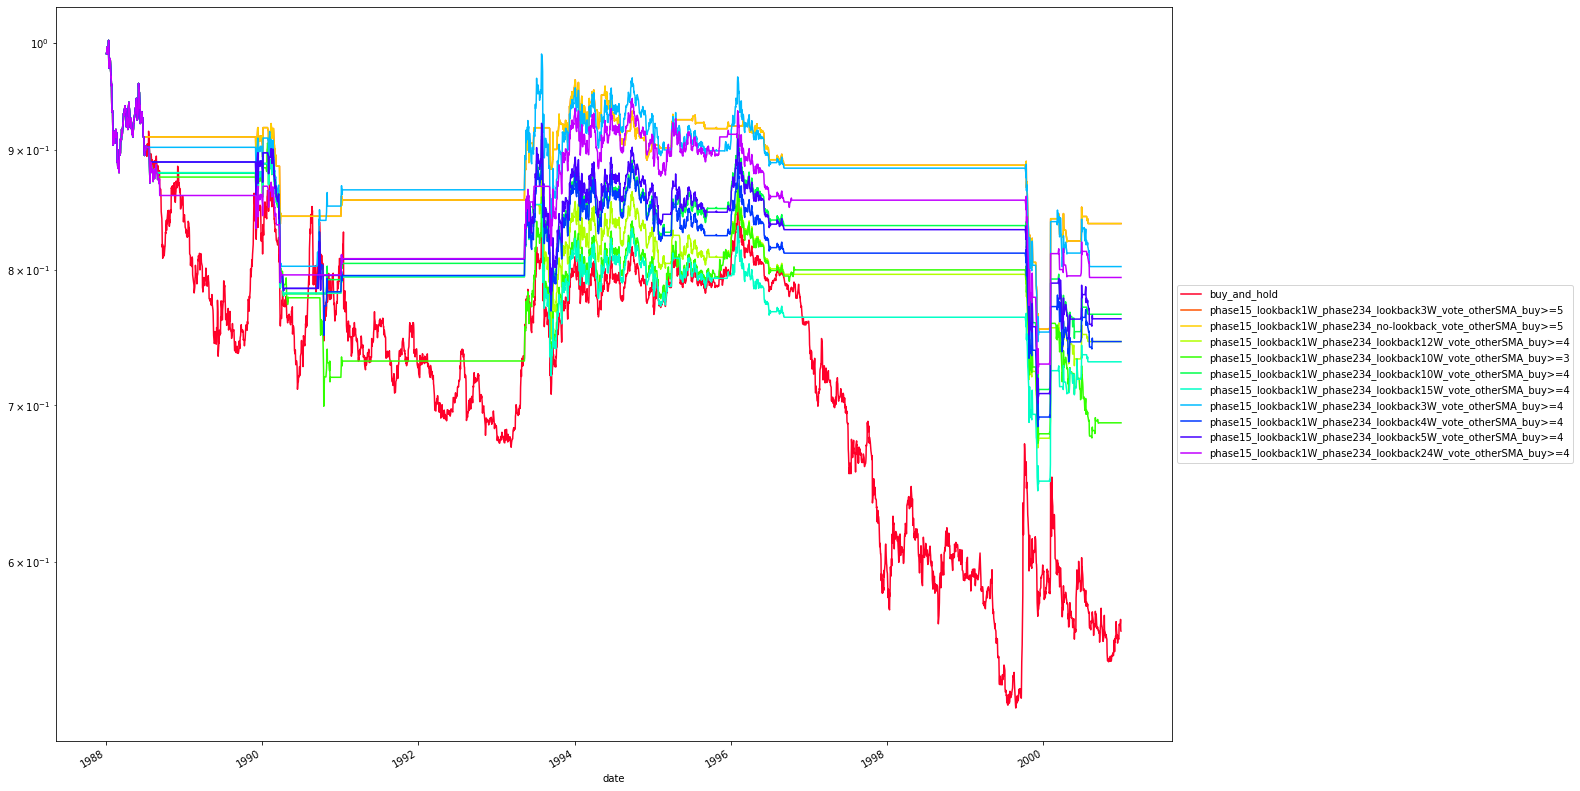

'2001-01-02 00:00:00 to 2005-12-30 00:00:00'

highlight_ratio  \
phase15_lookback1W_phase234_lookback3W_vote_oth...         0.700231   
phase15_lookback1W_phase234_no-lookback_vote_ot...         0.700231   
phase15_lookback1W_phase234_lookback12W_vote_ot...         0.820907   
phase15_lookback1W_phase234_lookback10W_vote_ot...         0.827825   
phase15_lookback1W_phase234_lookback10W_vote_ot...         0.809377   
phase15_lookback1W_phase234_lookback15W_vote_ot...         0.813221   
phase15_lookback1W_phase234_lookback3W_vote_oth...         0.839354   
phase15_lookback1W_phase234_lookback4W_vote_oth...         0.839354   
phase15_lookback1W_phase234_lookback5W_vote_oth...         0.835511   
phase15_lookback1W_phase234_lookback24W_vote_ot...         0.800154   

                                                    flip_ratio      accu  \
phase15_lookback1W_phase234_lookback3W_vote_oth...    0.053846  0.517294   
phase15_lookback1W_phase234_no-lookback_vote_ot...    0.053846  0.517294   
phase15_lookback1W_phase234_lookback12W_vote_ot...    0.022308  0.530361   
phase15_lookback1W_phase234_lookback10W_vote_ot...    0.027692  0.523444   
phase15_lookback1W_phase234_lookback10W_vote_ot...    0.026154  0.524981   
phase15_lookback1W_phase234_lookback15W_vote_ot...    0.022308  0.527287   
phase15_lookback1W_phase234_lookback3W_vote_oth...    0.023846  0.528824   
phase15_lookback1W_phase234_lookback4W_vote_oth...    0.023846  0.528824   
phase15_lookback1W_phase234_lookback5W_vote_oth...    0.023846  0.529593   
phase15_lookback1W_phase234_lookback24W_vote_ot...    0.020769  0.526518   

                                                        prec       mse  
phase15_lookback1W_phase234_lookback3W_vote_oth...  0.543359  1.225416  
phase15_lookback1W_phase234_no-lookback_vote_ot...  0.543359  1.225416  
phase15_lookback1W_phase234_lookback12W_vote_ot...  0.544944  1.202670  
phase15_lookback1W_phase234_lookback10W_vote_ot...  0.540390  1.209608  
phase15_lookback1W_phase234_lookback10W_vote_ot...  0.542260  1.203703  
phase15_lookback1W_phase234_lookback15W_vote_ot...  0.543478  1.202397  
phase15_lookback1W_phase234_lookback3W_vote_oth...  0.543040  1.208574  
phase15_lookback1W_phase234_lookback4W_vote_oth...  0.543040  1.208574  
phase15_lookback1W_phase234_lookback5W_vote_oth...  0.543698  1.205633  
phase15_lookback1W_phase234_lookback24W_vote_ot...  0.543708  1.210501

annual_return  \
buy_and_hold                                             0.132401   
phase15_lookback1W_phase234_lookback3W_vote_oth...       0.095394   
phase15_lookback1W_phase234_no-lookback_vote_ot...       0.095394   
phase15_lookback1W_phase234_lookback12W_vote_ot...       0.122982   
phase15_lookback1W_phase234_lookback10W_vote_ot...       0.114200   
phase15_lookback1W_phase234_lookback10W_vote_ot...       0.121825   
phase15_lookback1W_phase234_lookback15W_vote_ot...       0.123339   
phase15_lookback1W_phase234_lookback3W_vote_oth...       0.115350   
phase15_lookback1W_phase234_lookback4W_vote_oth...       0.115350   
phase15_lookback1W_phase234_lookback5W_vote_oth...       0.119130   
phase15_lookback1W_phase234_lookback24W_vote_ot...       0.113085   

                                                    sharpe_ratio  \
buy_and_hold                                            0.936292   
phase15_lookback1W_phase234_lookback3W_vote_oth...      0.810739   
phase15_lookback1W_phase234_no-lookback_vote_ot...      0.810739   
phase15_lookback1W_phase234_lookback12W_vote_ot...      0.956205   
phase15_lookback1W_phase234_lookback10W_vote_ot...      0.898938   
phase15_lookback1W_phase234_lookback10W_vote_ot...      0.955490   
phase15_lookback1W_phase234_lookback15W_vote_ot...      0.958952   
phase15_lookback1W_phase234_lookback3W_vote_oth...      0.900177   
phase15_lookback1W_phase234_lookback4W_vote_oth...      0.900177   
phase15_lookback1W_phase234_lookback5W_vote_oth...      0.927255   
phase15_lookback1W_phase234_lookback24W_vote_ot...      0.892083   

                                                    max_drawdown  \
buy_and_hold                                            -0.15445   
phase15_lookback1W_phase234_lookback3W_vote_oth...      -0.15445   
phase15_lookback1W_phase234_no-lookback_vote_ot...      -0.15445   
phase15_lookback1W_phase234_lookback12W_vote_ot...      -0.15445   
phase15_lookback1W_phase234_lookback10W_vote_ot...      -0.15445   
phase15_lookback1W_phase234_lookback10W_vote_ot...      -0.15445   
phase15_lookback1W_phase234_lookback15W_vote_ot...      -0.15445   
phase15_lookback1W_phase234_lookback3W_vote_oth...      -0.15445   
phase15_lookback1W_phase234_lookback4W_vote_oth...      -0.15445   
phase15_lookback1W_phase234_lookback5W_vote_oth...      -0.15445   
phase15_lookback1W_phase234_lookback24W_vote_ot...      -0.15445   

                                                    avg_drawdown  return/avgdd  
buy_and_hold                                           -0.042569      3.110238  
phase15_lookback1W_phase234_lookback3W_vote_oth...     -0.035756      2.667942  
phase15_lookback1W_phase234_no-lookback_vote_ot...     -0.035756      2.667942  
phase15_lookback1W_phase234_lookback12W_vote_ot...     -0.038197      3.219717  
phase15_lookback1W_phase234_lookback10W_vote_ot...     -0.039469      2.893406  
phase15_lookback1W_phase234_lookback10W_vote_ot...     -0.037788      3.223926  
phase15_lookback1W_phase234_lookback15W_vote_ot...     -0.038127      3.234949  
phase15_lookback1W_phase234_lookback3W_vote_oth...     -0.039878      2.892565  
phase15_lookback1W_phase234_lookback4W_vote_oth...     -0.039878      2.892565  
phase15_lookback1W_phase234_lookback5W_vote_oth...     -0.038870      3.064842  
phase15_lookback1W_phase234_lookback24W_vote_ot...     -0.038789      2.915374

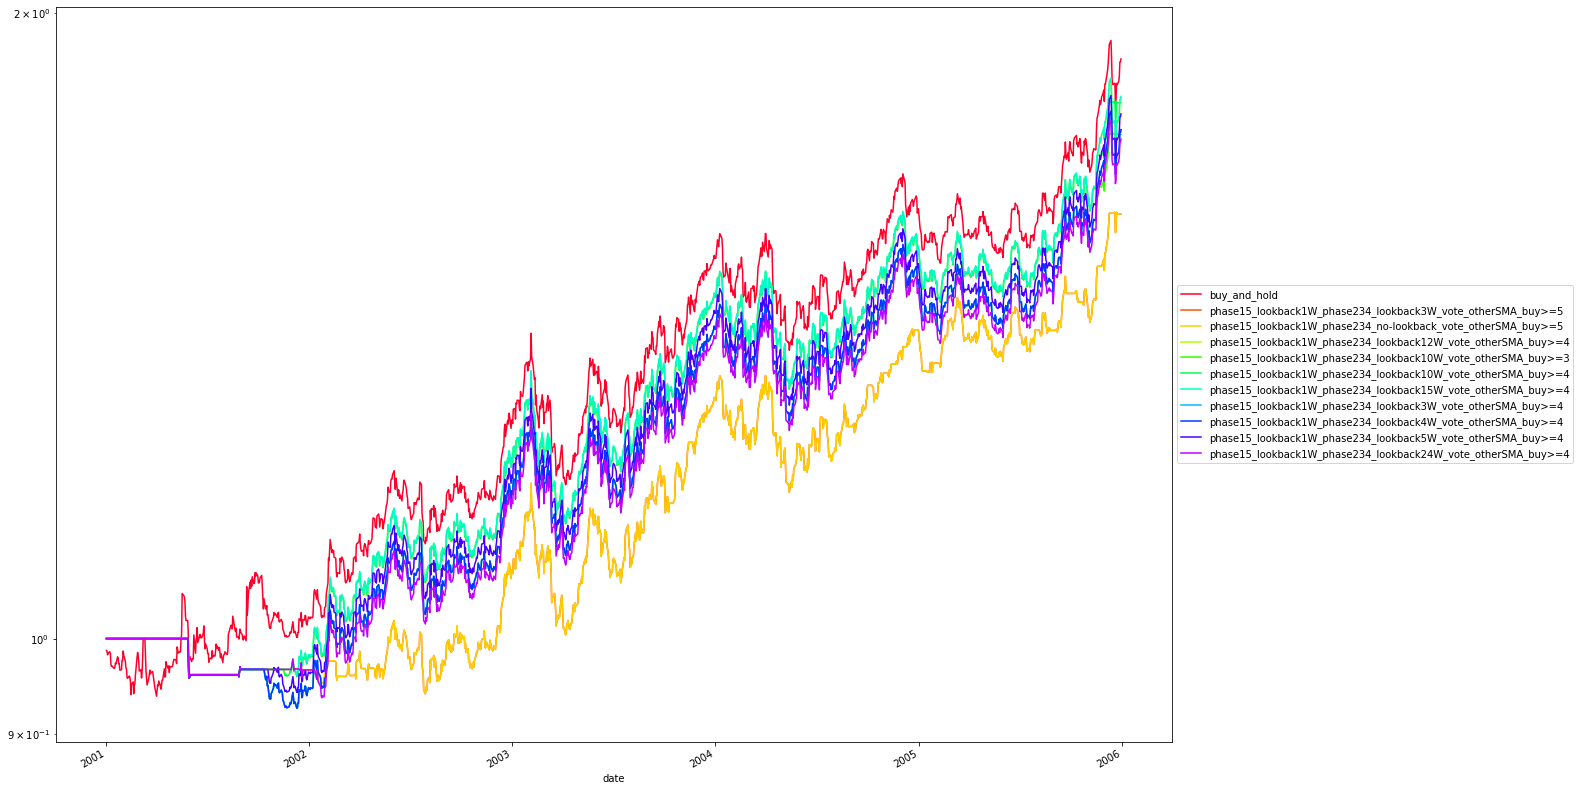

'2006-01-03 00:00:00 to 2008-12-31 00:00:00'

highlight_ratio  \
phase15_lookback1W_phase234_lookback3W_vote_oth...         0.829706   
phase15_lookback1W_phase234_no-lookback_vote_ot...         0.829706   
phase15_lookback1W_phase234_lookback12W_vote_ot...         0.944942   
phase15_lookback1W_phase234_lookback10W_vote_ot...         0.955186   
phase15_lookback1W_phase234_lookback10W_vote_ot...         0.932138   
phase15_lookback1W_phase234_lookback15W_vote_ot...         0.957746   
phase15_lookback1W_phase234_lookback3W_vote_oth...         0.944942   
phase15_lookback1W_phase234_lookback4W_vote_oth...         0.944942   
phase15_lookback1W_phase234_lookback5W_vote_oth...         0.944942   
phase15_lookback1W_phase234_lookback24W_vote_ot...         0.967990   

                                                    flip_ratio      accu  \
phase15_lookback1W_phase234_lookback3W_vote_oth...    0.037179  0.524968   
phase15_lookback1W_phase234_no-lookback_vote_ot...    0.037179  0.524968   
phase15_lookback1W_phase234_lookback12W_vote_ot...    0.014103  0.517286   
phase15_lookback1W_phase234_lookback10W_vote_ot...    0.020513  0.522407   
phase15_lookback1W_phase234_lookback10W_vote_ot...    0.016667  0.519846   
phase15_lookback1W_phase234_lookback15W_vote_ot...    0.016667  0.517286   
phase15_lookback1W_phase234_lookback3W_vote_oth...    0.014103  0.517286   
phase15_lookback1W_phase234_lookback4W_vote_oth...    0.014103  0.517286   
phase15_lookback1W_phase234_lookback5W_vote_oth...    0.014103  0.517286   
phase15_lookback1W_phase234_lookback24W_vote_ot...    0.017949  0.519846   

                                                        prec       mse  
phase15_lookback1W_phase234_lookback3W_vote_oth...  0.533951  1.221857  
phase15_lookback1W_phase234_no-lookback_vote_ot...  0.533951  1.221857  
phase15_lookback1W_phase234_lookback12W_vote_ot...  0.525745  1.232305  
phase15_lookback1W_phase234_lookback10W_vote_ot...  0.528150  1.221282  
phase15_lookback1W_phase234_lookback10W_vote_ot...  0.527473  1.230935  
phase15_lookback1W_phase234_lookback15W_vote_ot...  0.525401  1.230866  
phase15_lookback1W_phase234_lookback3W_vote_oth...  0.525745  1.232305  
phase15_lookback1W_phase234_lookback4W_vote_oth...  0.525745  1.232305  
phase15_lookback1W_phase234_lookback5W_vote_oth...  0.525745  1.232305  
phase15_lookback1W_phase234_lookback24W_vote_ot...  0.526455  1.222653

annual_return  \
buy_and_hold                                             0.186867   
phase15_lookback1W_phase234_lookback3W_vote_oth...       0.142554   
phase15_lookback1W_phase234_no-lookback_vote_ot...       0.142554   
phase15_lookback1W_phase234_lookback12W_vote_ot...       0.117365   
phase15_lookback1W_phase234_lookback10W_vote_ot...       0.140743   
phase15_lookback1W_phase234_lookback10W_vote_ot...       0.120987   
phase15_lookback1W_phase234_lookback15W_vote_ot...       0.119324   
phase15_lookback1W_phase234_lookback3W_vote_oth...       0.117365   
phase15_lookback1W_phase234_lookback4W_vote_oth...       0.117365   
phase15_lookback1W_phase234_lookback5W_vote_oth...       0.117365   
phase15_lookback1W_phase234_lookback24W_vote_ot...       0.137057   

                                                    sharpe_ratio  \
buy_and_hold                                            0.824008   
phase15_lookback1W_phase234_lookback3W_vote_oth...      0.712651   
phase15_lookback1W_phase234_no-lookback_vote_ot...      0.712651   
phase15_lookback1W_phase234_lookback12W_vote_ot...      0.596668   
phase15_lookback1W_phase234_lookback10W_vote_ot...      0.681274   
phase15_lookback1W_phase234_lookback10W_vote_ot...      0.614933   
phase15_lookback1W_phase234_lookback15W_vote_ot...      0.597361   
phase15_lookback1W_phase234_lookback3W_vote_oth...      0.596668   
phase15_lookback1W_phase234_lookback4W_vote_oth...      0.596668   
phase15_lookback1W_phase234_lookback5W_vote_oth...      0.596668   
phase15_lookback1W_phase234_lookback24W_vote_ot...      0.662858   

                                                    max_drawdown  \
buy_and_hold                                           -0.290117   
phase15_lookback1W_phase234_lookback3W_vote_oth...     -0.279944   
phase15_lookback1W_phase234_no-lookback_vote_ot...     -0.279944   
phase15_lookback1W_phase234_lookback12W_vote_ot...     -0.302053   
phase15_lookback1W_phase234_lookback10W_vote_ot...     -0.325429   
phase15_lookback1W_phase234_lookback10W_vote_ot...     -0.302053   
phase15_lookback1W_phase234_lookback15W_vote_ot...     -0.325429   
phase15_lookback1W_phase234_lookback3W_vote_oth...     -0.302053   
phase15_lookback1W_phase234_lookback4W_vote_oth...     -0.302053   
phase15_lookback1W_phase234_lookback5W_vote_oth...     -0.302053   
phase15_lookback1W_phase234_lookback24W_vote_ot...     -0.325429   

                                                    avg_drawdown  return/avgdd  
buy_and_hold                                           -0.090528      2.064197  
phase15_lookback1W_phase234_lookback3W_vote_oth...     -0.089560      1.591706  
phase15_lookback1W_phase234_no-lookback_vote_ot...     -0.089560      1.591706  
phase15_lookback1W_phase234_lookback12W_vote_ot...     -0.094208      1.245805  
phase15_lookback1W_phase234_lookback10W_vote_ot...     -0.093542      1.504597  
phase15_lookback1W_phase234_lookback10W_vote_ot...     -0.093436      1.294865  
phase15_lookback1W_phase234_lookback15W_vote_ot...     -0.094509      1.262576  
phase15_lookback1W_phase234_lookback3W_vote_oth...     -0.094208      1.245805  
phase15_lookback1W_phase234_lookback4W_vote_oth...     -0.094208      1.245805  
phase15_lookback1W_phase234_lookback5W_vote_oth...     -0.094208      1.245805  
phase15_lookback1W_phase234_lookback24W_vote_ot...     -0.094314      1.453198

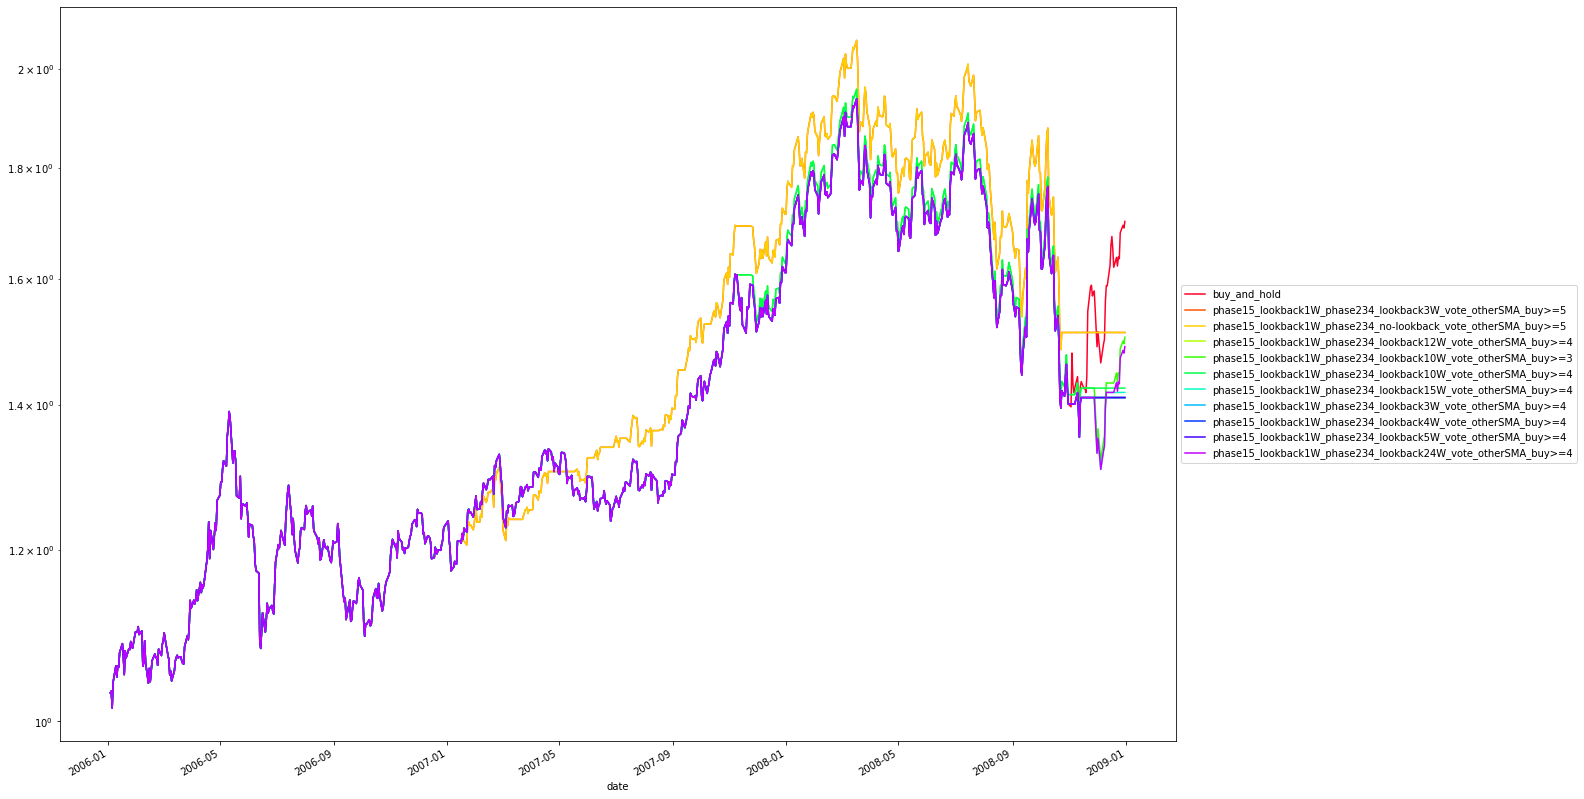

'2009-01-01 00:00:00 to 2011-12-30 00:00:00'

highlight_ratio  \
phase15_lookback1W_phase234_lookback3W_vote_oth...         0.785166   
phase15_lookback1W_phase234_no-lookback_vote_ot...         0.785166   
phase15_lookback1W_phase234_lookback12W_vote_ot...         0.976982   
phase15_lookback1W_phase234_lookback10W_vote_ot...         0.998721   
phase15_lookback1W_phase234_lookback10W_vote_ot...         0.983376   
phase15_lookback1W_phase234_lookback15W_vote_ot...         0.976982   
phase15_lookback1W_phase234_lookback3W_vote_oth...         0.996164   
phase15_lookback1W_phase234_lookback4W_vote_oth...         0.996164   
phase15_lookback1W_phase234_lookback5W_vote_oth...         0.996164   
phase15_lookback1W_phase234_lookback24W_vote_ot...         0.998721   

                                                    flip_ratio      accu  \
phase15_lookback1W_phase234_lookback3W_vote_oth...    0.034571  0.523018   
phase15_lookback1W_phase234_no-lookback_vote_ot...    0.034571  0.523018   
phase15_lookback1W_phase234_lookback12W_vote_ot...    0.006402  0.551151   
phase15_lookback1W_phase234_lookback10W_vote_ot...    0.002561  0.554987   
phase15_lookback1W_phase234_lookback10W_vote_ot...    0.006402  0.552430   
phase15_lookback1W_phase234_lookback15W_vote_ot...    0.006402  0.551151   
phase15_lookback1W_phase234_lookback3W_vote_oth...    0.003841  0.554987   
phase15_lookback1W_phase234_lookback4W_vote_oth...    0.003841  0.554987   
phase15_lookback1W_phase234_lookback5W_vote_oth...    0.003841  0.554987   
phase15_lookback1W_phase234_lookback24W_vote_ot...    0.002561  0.554987   

                                                        prec       mse  
phase15_lookback1W_phase234_lookback3W_vote_oth...  0.550489  1.228729  
phase15_lookback1W_phase234_no-lookback_vote_ot...  0.550489  1.228729  
phase15_lookback1W_phase234_lookback12W_vote_ot...  0.554974  1.201592  
phase15_lookback1W_phase234_lookback10W_vote_ot...  0.555698  1.185051  
phase15_lookback1W_phase234_lookback10W_vote_ot...  0.555267  1.205317  
phase15_lookback1W_phase234_lookback15W_vote_ot...  0.554974  1.201592  
phase15_lookback1W_phase234_lookback3W_vote_oth...  0.555841  1.184153  
phase15_lookback1W_phase234_lookback4W_vote_oth...  0.555841  1.184153  
phase15_lookback1W_phase234_lookback5W_vote_oth...  0.555841  1.184153  
phase15_lookback1W_phase234_lookback24W_vote_ot...  0.555698  1.185051

annual_return  \
buy_and_hold                                             0.203590   
phase15_lookback1W_phase234_lookback3W_vote_oth...       0.132618   
phase15_lookback1W_phase234_no-lookback_vote_ot...       0.132618   
phase15_lookback1W_phase234_lookback12W_vote_ot...       0.175376   
phase15_lookback1W_phase234_lookback10W_vote_ot...       0.203590   
phase15_lookback1W_phase234_lookback10W_vote_ot...       0.168722   
phase15_lookback1W_phase234_lookback15W_vote_ot...       0.175376   
phase15_lookback1W_phase234_lookback3W_vote_oth...       0.205202   
phase15_lookback1W_phase234_lookback4W_vote_oth...       0.205202   
phase15_lookback1W_phase234_lookback5W_vote_oth...       0.205202   
phase15_lookback1W_phase234_lookback24W_vote_ot...       0.203590   

                                                    sharpe_ratio  \
buy_and_hold                                            1.084884   
phase15_lookback1W_phase234_lookback3W_vote_oth...      0.841256   
phase15_lookback1W_phase234_no-lookback_vote_ot...      0.841256   
phase15_lookback1W_phase234_lookback12W_vote_ot...      0.976994   
phase15_lookback1W_phase234_lookback10W_vote_ot...      1.084884   
phase15_lookback1W_phase234_lookback10W_vote_ot...      0.942488   
phase15_lookback1W_phase234_lookback15W_vote_ot...      0.976994   
phase15_lookback1W_phase234_lookback3W_vote_oth...      1.092267   
phase15_lookback1W_phase234_lookback4W_vote_oth...      1.092267   
phase15_lookback1W_phase234_lookback5W_vote_oth...      1.092267   
phase15_lookback1W_phase234_lookback24W_vote_ot...      1.084884   

                                                    max_drawdown  \
buy_and_hold                                           -0.186157   
phase15_lookback1W_phase234_lookback3W_vote_oth...     -0.186157   
phase15_lookback1W_phase234_no-lookback_vote_ot...     -0.186157   
phase15_lookback1W_phase234_lookback12W_vote_ot...     -0.186157   
phase15_lookback1W_phase234_lookback10W_vote_ot...     -0.186157   
phase15_lookback1W_phase234_lookback10W_vote_ot...     -0.186157   
phase15_lookback1W_phase234_lookback15W_vote_ot...     -0.186157   
phase15_lookback1W_phase234_lookback3W_vote_oth...     -0.186157   
phase15_lookback1W_phase234_lookback4W_vote_oth...     -0.186157   
phase15_lookback1W_phase234_lookback5W_vote_oth...     -0.186157   
phase15_lookback1W_phase234_lookback24W_vote_ot...     -0.186157   

                                                    avg_drawdown  return/avgdd  
buy_and_hold                                           -0.044423      4.583029  
phase15_lookback1W_phase234_lookback3W_vote_oth...     -0.031901      4.157112  
phase15_lookback1W_phase234_no-lookback_vote_ot...     -0.031901      4.157112  
phase15_lookback1W_phase234_lookback12W_vote_ot...     -0.044778      3.916534  
phase15_lookback1W_phase234_lookback10W_vote_ot...     -0.044423      4.583029  
phase15_lookback1W_phase234_lookback10W_vote_ot...     -0.045041      3.745981  
phase15_lookback1W_phase234_lookback15W_vote_ot...     -0.044778      3.916534  
phase15_lookback1W_phase234_lookback3W_vote_oth...     -0.044305      4.631573  
phase15_lookback1W_phase234_lookback4W_vote_oth...     -0.044305      4.631573  
phase15_lookback1W_phase234_lookback5W_vote_oth...     -0.044305      4.631573  
phase15_lookback1W_phase234_lookback24W_vote_ot...     -0.044423      4.583029

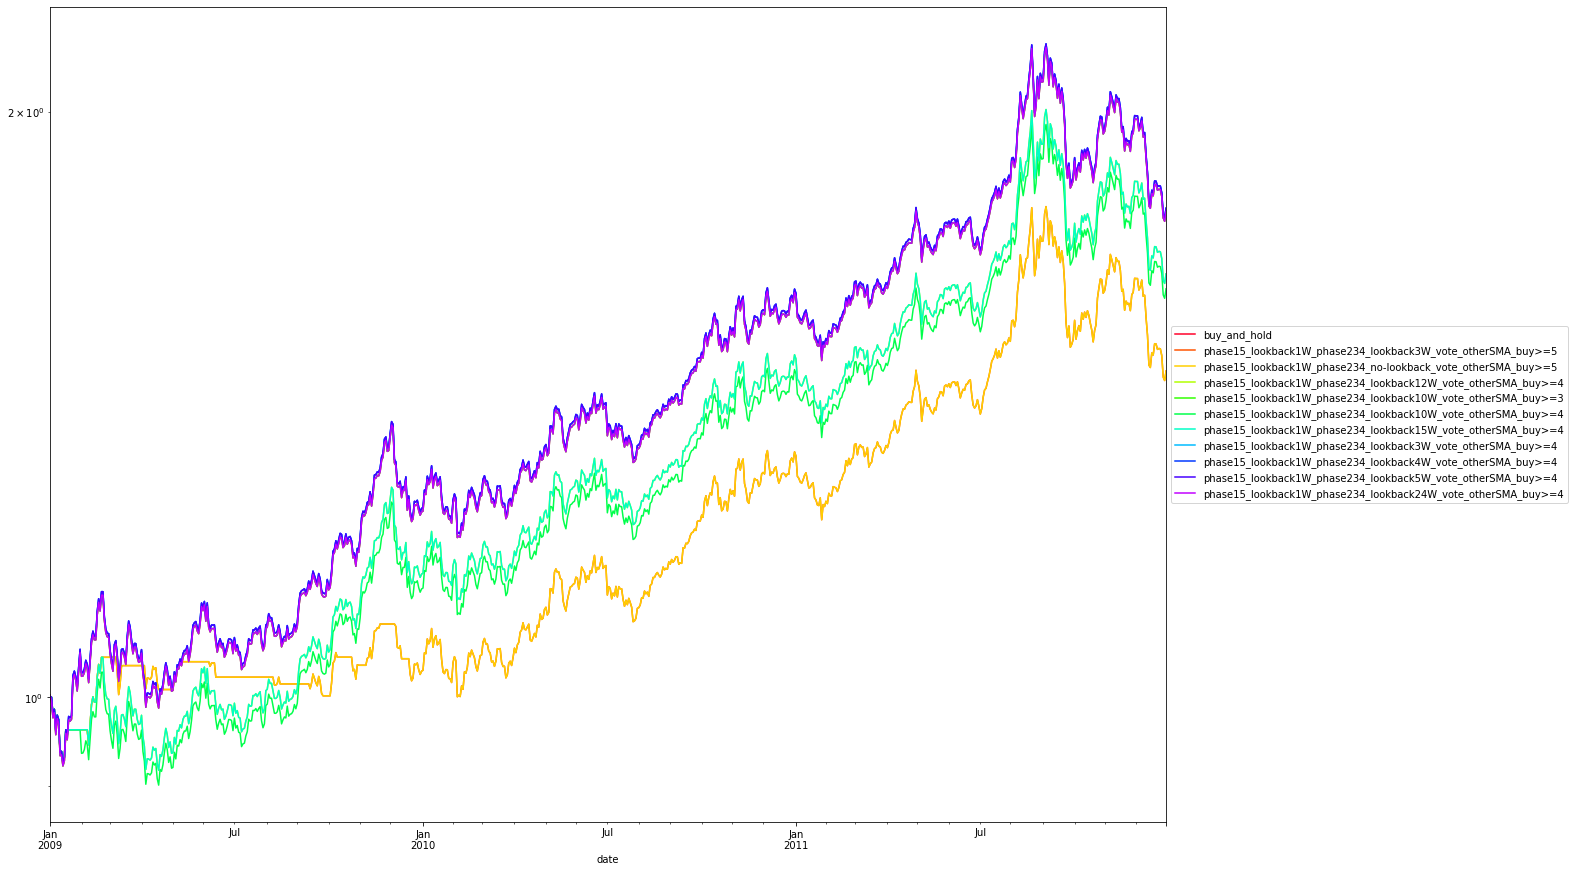

'2012-01-02 00:00:00 to 2015-12-31 00:00:00'

highlight_ratio  \
phase15_lookback1W_phase234_lookback3W_vote_oth...         0.163148   
phase15_lookback1W_phase234_no-lookback_vote_ot...         0.163148   
phase15_lookback1W_phase234_lookback12W_vote_ot...         0.292706   
phase15_lookback1W_phase234_lookback10W_vote_ot...         0.306142   
phase15_lookback1W_phase234_lookback10W_vote_ot...         0.292706   
phase15_lookback1W_phase234_lookback15W_vote_ot...         0.297505   
phase15_lookback1W_phase234_lookback3W_vote_oth...         0.273512   
phase15_lookback1W_phase234_lookback4W_vote_oth...         0.273512   
phase15_lookback1W_phase234_lookback5W_vote_oth...         0.263916   
phase15_lookback1W_phase234_lookback24W_vote_ot...         0.310940   

                                                    flip_ratio      accu  \
phase15_lookback1W_phase234_lookback3W_vote_oth...    0.020173  0.509597   
phase15_lookback1W_phase234_no-lookback_vote_ot...    0.020173  0.509597   
phase15_lookback1W_phase234_lookback12W_vote_ot...    0.000961  0.525912   
phase15_lookback1W_phase234_lookback10W_vote_ot...    0.002882  0.525912   
phase15_lookback1W_phase234_lookback10W_vote_ot...    0.000961  0.525912   
phase15_lookback1W_phase234_lookback15W_vote_ot...    0.000961  0.524952   
phase15_lookback1W_phase234_lookback3W_vote_oth...    0.002882  0.523992   
phase15_lookback1W_phase234_lookback4W_vote_oth...    0.002882  0.529750   
phase15_lookback1W_phase234_lookback5W_vote_oth...    0.000961  0.529750   
phase15_lookback1W_phase234_lookback24W_vote_ot...    0.002882  0.524952   

                                                        prec       mse  
phase15_lookback1W_phase234_lookback3W_vote_oth...  0.482353  1.216066  
phase15_lookback1W_phase234_no-lookback_vote_ot...  0.482353  1.216066  
phase15_lookback1W_phase234_lookback12W_vote_ot...  0.518033  1.215185  
phase15_lookback1W_phase234_lookback10W_vote_ot...  0.517241  1.214503  
phase15_lookback1W_phase234_lookback10W_vote_ot...  0.518033  1.215185  
phase15_lookback1W_phase234_lookback15W_vote_ot...  0.516129  1.214812  
phase15_lookback1W_phase234_lookback3W_vote_oth...  0.515789  1.215080  
phase15_lookback1W_phase234_lookback4W_vote_oth...  0.526316  1.206785  
phase15_lookback1W_phase234_lookback5W_vote_oth...  0.527273  1.202877  
phase15_lookback1W_phase234_lookback24W_vote_ot...  0.515432  1.216175

annual_return  \
buy_and_hold                                            -0.089555   
phase15_lookback1W_phase234_lookback3W_vote_oth...       0.001578   
phase15_lookback1W_phase234_no-lookback_vote_ot...       0.001578   
phase15_lookback1W_phase234_lookback12W_vote_ot...       0.001687   
phase15_lookback1W_phase234_lookback10W_vote_ot...       0.002549   
phase15_lookback1W_phase234_lookback10W_vote_ot...       0.001687   
phase15_lookback1W_phase234_lookback15W_vote_ot...       0.002165   
phase15_lookback1W_phase234_lookback3W_vote_oth...       0.001929   
phase15_lookback1W_phase234_lookback4W_vote_oth...       0.012710   
phase15_lookback1W_phase234_lookback5W_vote_oth...       0.017985   
phase15_lookback1W_phase234_lookback24W_vote_ot...       0.000303   

                                                    sharpe_ratio  \
buy_and_hold                                           -0.494734   
phase15_lookback1W_phase234_lookback3W_vote_oth...      0.056612   
phase15_lookback1W_phase234_no-lookback_vote_ot...      0.056612   
phase15_lookback1W_phase234_lookback12W_vote_ot...      0.060623   
phase15_lookback1W_phase234_lookback10W_vote_ot...      0.071682   
phase15_lookback1W_phase234_lookback10W_vote_ot...      0.060623   
phase15_lookback1W_phase234_lookback15W_vote_ot...      0.066748   
phase15_lookback1W_phase234_lookback3W_vote_oth...      0.063477   
phase15_lookback1W_phase234_lookback4W_vote_oth...      0.202950   
phase15_lookback1W_phase234_lookback5W_vote_oth...      0.275667   
phase15_lookback1W_phase234_lookback24W_vote_ot...      0.043496   

                                                    max_drawdown  \
buy_and_hold                                           -0.412616   
phase15_lookback1W_phase234_lookback3W_vote_oth...     -0.123328   
phase15_lookback1W_phase234_no-lookback_vote_ot...     -0.123328   
phase15_lookback1W_phase234_lookback12W_vote_ot...     -0.137638   
phase15_lookback1W_phase234_lookback10W_vote_ot...     -0.137638   
phase15_lookback1W_phase234_lookback10W_vote_ot...     -0.137638   
phase15_lookback1W_phase234_lookback15W_vote_ot...     -0.137638   
phase15_lookback1W_phase234_lookback3W_vote_oth...     -0.137638   
phase15_lookback1W_phase234_lookback4W_vote_oth...     -0.137638   
phase15_lookback1W_phase234_lookback5W_vote_oth...     -0.137638   
phase15_lookback1W_phase234_lookback24W_vote_ot...     -0.141120   

                                                    avg_drawdown  return/avgdd  
buy_and_hold                                           -0.229167     -0.390783  
phase15_lookback1W_phase234_lookback3W_vote_oth...     -0.104614      0.015084  
phase15_lookback1W_phase234_no-lookback_vote_ot...     -0.104614      0.015084  
phase15_lookback1W_phase234_lookback12W_vote_ot...     -0.103257      0.016337  
phase15_lookback1W_phase234_lookback10W_vote_ot...     -0.100983      0.025246  
phase15_lookback1W_phase234_lookback10W_vote_ot...     -0.103257      0.016337  
phase15_lookback1W_phase234_lookback15W_vote_ot...     -0.102029      0.021217  
phase15_lookback1W_phase234_lookback3W_vote_oth...     -0.102801      0.018761  
phase15_lookback1W_phase234_lookback4W_vote_oth...     -0.073837      0.172140  
phase15_lookback1W_phase234_lookback5W_vote_oth...     -0.059591      0.301801  
phase15_lookback1W_phase234_lookback24W_vote_ot...     -0.106621      0.002845

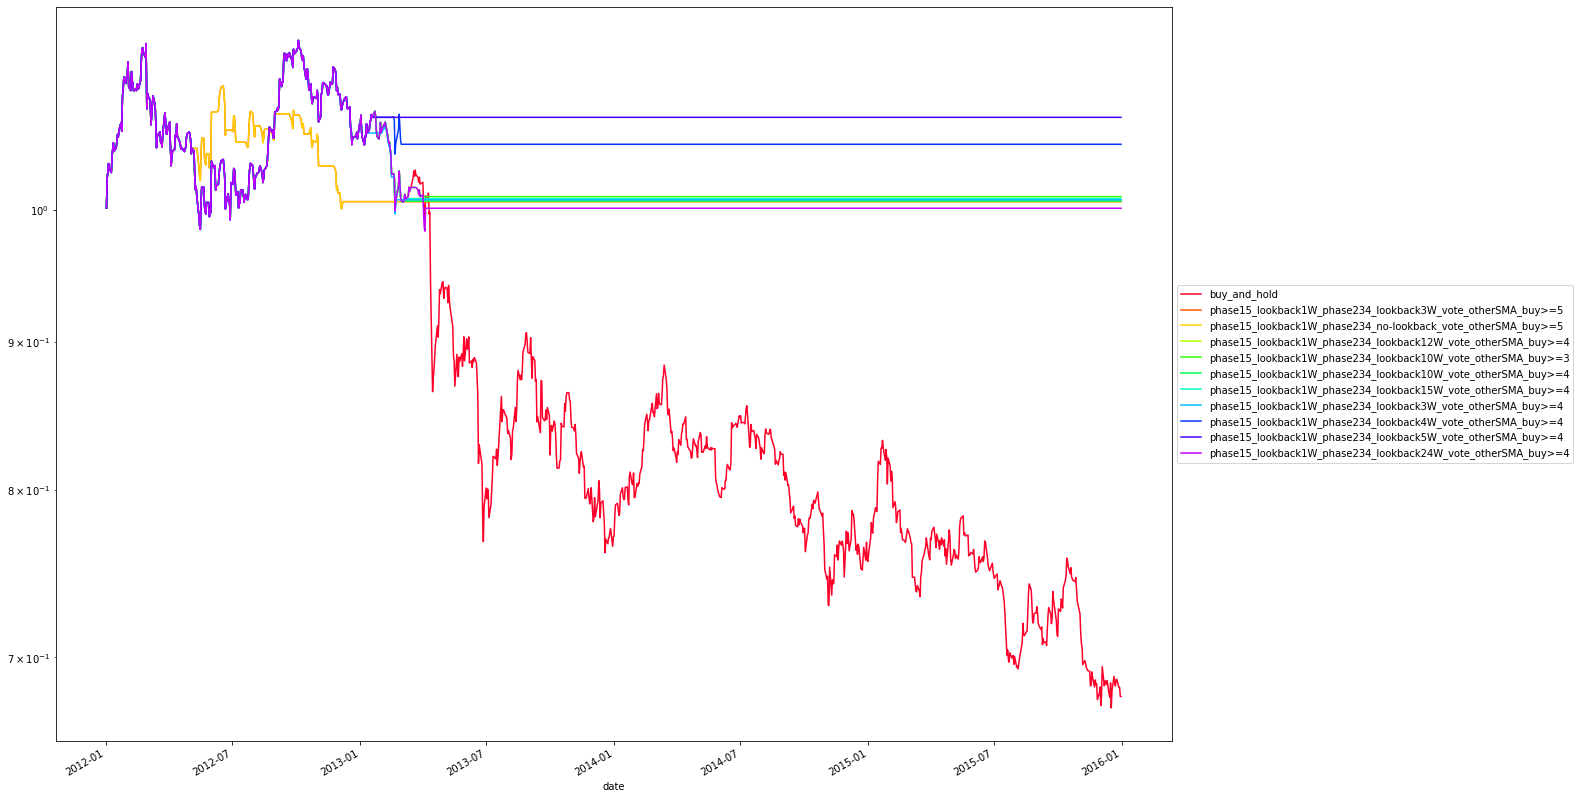

'2016-01-01 00:00:00 to 2021-12-31 00:00:00'

highlight_ratio  \
phase15_lookback1W_phase234_lookback3W_vote_oth...         0.508637   
phase15_lookback1W_phase234_no-lookback_vote_ot...         0.508637   
phase15_lookback1W_phase234_lookback12W_vote_ot...         0.795266   
phase15_lookback1W_phase234_lookback10W_vote_ot...         0.799104   
phase15_lookback1W_phase234_lookback10W_vote_ot...         0.776711   
phase15_lookback1W_phase234_lookback15W_vote_ot...         0.783109   
phase15_lookback1W_phase234_lookback3W_vote_oth...         0.795266   
phase15_lookback1W_phase234_lookback4W_vote_oth...         0.798464   
phase15_lookback1W_phase234_lookback5W_vote_oth...         0.782470   
phase15_lookback1W_phase234_lookback24W_vote_ot...         0.789507   

                                                    flip_ratio      accu  \
phase15_lookback1W_phase234_lookback3W_vote_oth...    0.067862  0.491363   
phase15_lookback1W_phase234_no-lookback_vote_ot...    0.067862  0.491363   
phase15_lookback1W_phase234_lookback12W_vote_ot...    0.015365  0.511836   
phase15_lookback1W_phase234_lookback10W_vote_ot...    0.017926  0.511836   
phase15_lookback1W_phase234_lookback10W_vote_ot...    0.021767  0.508637   
phase15_lookback1W_phase234_lookback15W_vote_ot...    0.019206  0.511196   
phase15_lookback1W_phase234_lookback3W_vote_oth...    0.012804  0.510557   
phase15_lookback1W_phase234_lookback4W_vote_oth...    0.011524  0.509917   
phase15_lookback1W_phase234_lookback5W_vote_oth...    0.011524  0.506718   
phase15_lookback1W_phase234_lookback24W_vote_ot...    0.024328  0.513756   

                                                        prec       mse  
phase15_lookback1W_phase234_lookback3W_vote_oth...  0.527044  1.277547  
phase15_lookback1W_phase234_no-lookback_vote_ot...  0.527044  1.277547  
phase15_lookback1W_phase234_lookback12W_vote_ot...  0.530169  1.259457  
phase15_lookback1W_phase234_lookback10W_vote_ot...  0.530024  1.260773  
phase15_lookback1W_phase234_lookback10W_vote_ot...  0.528830  1.260399  
phase15_lookback1W_phase234_lookback15W_vote_ot...  0.530229  1.259862  
phase15_lookback1W_phase234_lookback3W_vote_oth...  0.529364  1.261321  
phase15_lookback1W_phase234_lookback4W_vote_oth...  0.528846  1.256661  
phase15_lookback1W_phase234_lookback5W_vote_oth...  0.527392  1.260924  
phase15_lookback1W_phase234_lookback24W_vote_ot...  0.531605  1.264160

annual_return  \
buy_and_hold                                             0.091659   
phase15_lookback1W_phase234_lookback3W_vote_oth...       0.014520   
phase15_lookback1W_phase234_no-lookback_vote_ot...       0.014520   
phase15_lookback1W_phase234_lookback12W_vote_ot...       0.032548   
phase15_lookback1W_phase234_lookback10W_vote_ot...       0.031061   
phase15_lookback1W_phase234_lookback10W_vote_ot...       0.031592   
phase15_lookback1W_phase234_lookback15W_vote_ot...       0.032204   
phase15_lookback1W_phase234_lookback3W_vote_oth...       0.030457   
phase15_lookback1W_phase234_lookback4W_vote_oth...       0.035629   
phase15_lookback1W_phase234_lookback5W_vote_oth...       0.030986   
phase15_lookback1W_phase234_lookback24W_vote_ot...       0.027520   

                                                    sharpe_ratio  \
buy_and_hold                                            0.718013   
phase15_lookback1W_phase234_lookback3W_vote_oth...      0.186490   
phase15_lookback1W_phase234_no-lookback_vote_ot...      0.186490   
phase15_lookback1W_phase234_lookback12W_vote_ot...      0.319691   
phase15_lookback1W_phase234_lookback10W_vote_ot...      0.307698   
phase15_lookback1W_phase234_lookback10W_vote_ot...      0.313223   
phase15_lookback1W_phase234_lookback15W_vote_ot...      0.318261   
phase15_lookback1W_phase234_lookback3W_vote_oth...      0.303011   
phase15_lookback1W_phase234_lookback4W_vote_oth...      0.343436   
phase15_lookback1W_phase234_lookback5W_vote_oth...      0.308177   
phase15_lookback1W_phase234_lookback24W_vote_ot...      0.282017   

                                                    max_drawdown  \
buy_and_hold                                           -0.185126   
phase15_lookback1W_phase234_lookback3W_vote_oth...     -0.213775   
phase15_lookback1W_phase234_no-lookback_vote_ot...     -0.213775   
phase15_lookback1W_phase234_lookback12W_vote_ot...     -0.213110   
phase15_lookback1W_phase234_lookback10W_vote_ot...     -0.202226   
phase15_lookback1W_phase234_lookback10W_vote_ot...     -0.198443   
phase15_lookback1W_phase234_lookback15W_vote_ot...     -0.222307   
phase15_lookback1W_phase234_lookback3W_vote_oth...     -0.216372   
phase15_lookback1W_phase234_lookback4W_vote_oth...     -0.211293   
phase15_lookback1W_phase234_lookback5W_vote_oth...     -0.228870   
phase15_lookback1W_phase234_lookback24W_vote_ot...     -0.203624   

                                                    avg_drawdown  return/avgdd  
buy_and_hold                                           -0.066784      1.372467  
phase15_lookback1W_phase234_lookback3W_vote_oth...     -0.117779      0.123285  
phase15_lookback1W_phase234_no-lookback_vote_ot...     -0.117779      0.123285  
phase15_lookback1W_phase234_lookback12W_vote_ot...     -0.106391      0.305932  
phase15_lookback1W_phase234_lookback10W_vote_ot...     -0.102494      0.303048  
phase15_lookback1W_phase234_lookback10W_vote_ot...     -0.100058      0.315733  
phase15_lookback1W_phase234_lookback15W_vote_ot...     -0.114763      0.280612  
phase15_lookback1W_phase234_lookback3W_vote_oth...     -0.108850      0.279806  
phase15_lookback1W_phase234_lookback4W_vote_oth...     -0.106084      0.335857  
phase15_lookback1W_phase234_lookback5W_vote_oth...     -0.115262      0.268834  
phase15_lookback1W_phase234_lookback24W_vote_ot...     -0.106010      0.259595

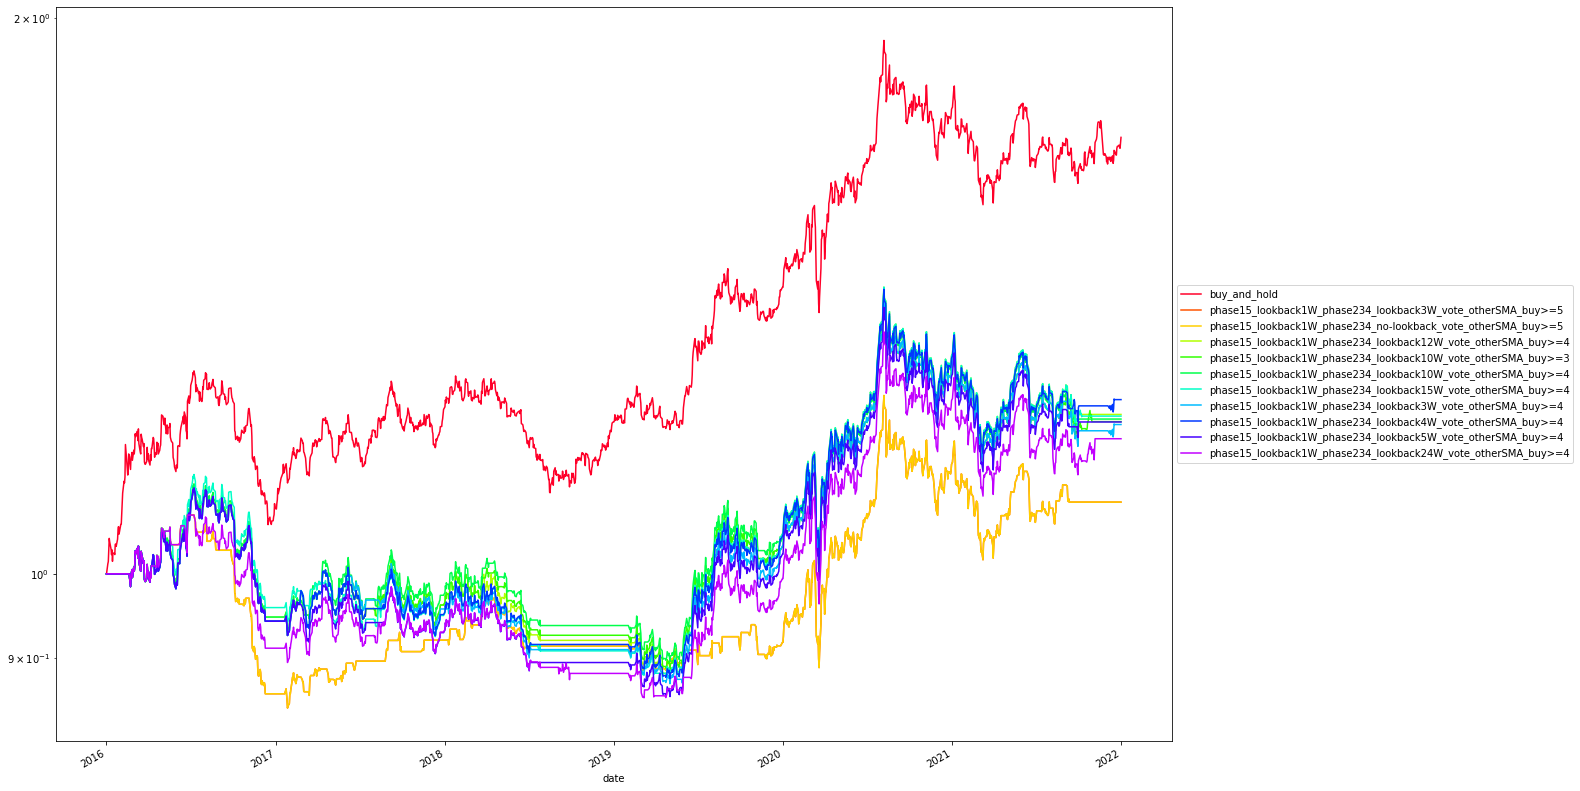

['buy_and_hold',
 'phase15_lookback1W_phase234_lookback3W_vote_otherSMA_buy>=5',
 'phase15_lookback1W_phase234_no-lookback_vote_otherSMA_buy>=5',
 'phase15_lookback1W_phase234_lookback12W_vote_otherSMA_buy>=4',
 'phase15_lookback1W_phase234_lookback10W_vote_otherSMA_buy>=3',
 'phase15_lookback1W_phase234_lookback10W_vote_otherSMA_buy>=4',
 'phase15_lookback1W_phase234_lookback15W_vote_otherSMA_buy>=4',
 'phase15_lookback1W_phase234_lookback3W_vote_otherSMA_buy>=4',
 'phase15_lookback1W_phase234_lookback4W_vote_otherSMA_buy>=4',
 'phase15_lookback1W_phase234_lookback5W_vote_otherSMA_buy>=4',
 'phase15_lookback1W_phase234_lookback24W_vote_otherSMA_buy>=4']

In [45]:
strategy_list_sel = print_all_result(ret_sma_cross)

print_all_result(ret_sma_cross['1988':'2000'], strategy_list_sel=strategy_list_sel)
print_all_result(ret_sma_cross['2001':'2005'], strategy_list_sel=strategy_list_sel)
print_all_result(ret_sma_cross['2006':'2008'], strategy_list_sel=strategy_list_sel)
print_all_result(ret_sma_cross['2009':'2011'], strategy_list_sel=strategy_list_sel)
print_all_result(ret_sma_cross['2012':'2015'], strategy_list_sel=strategy_list_sel)
print_all_result(ret_sma_cross['2016':'2021'], strategy_list_sel=strategy_list_sel)

'1985-01-02 00:00:00 to 2021-12-31 00:00:00'

highlight_ratio  \
phase15_lookback1W_phase234_no-lookback_vote_ot...         0.612047   
phase15_lookback1W_phase234_no-lookback_vote_ot...         0.494902   
phase15_lookback1W_phase234_no-lookback_vote_ot...         0.471286   
phase15_lookback1W_phase234_no-lookback_vote_ot...         0.317000   

                                                    flip_ratio      accu  \
phase15_lookback1W_phase234_no-lookback_vote_ot...    0.060348  0.510612   
phase15_lookback1W_phase234_no-lookback_vote_ot...    0.035584  0.514773   
phase15_lookback1W_phase234_no-lookback_vote_ot...    0.032047  0.514045   
phase15_lookback1W_phase234_no-lookback_vote_ot...    0.021642  0.507491   

                                                        prec       mse  
phase15_lookback1W_phase234_no-lookback_vote_ot...  0.522523  1.246155  
phase15_lookback1W_phase234_no-lookback_vote_ot...  0.532058  1.242305  
phase15_lookback1W_phase234_no-lookback_vote_ot...  0.532892  1.240295  
phase15_lookback1W_phase234_no-lookback_vote_ot...  0.538563  1.243066

annual_return  \
buy_and_hold                                             0.047776   
phase15_lookback1W_phase234_no-lookback_vote_ot...       0.027387   
phase15_lookback1W_phase234_no-lookback_vote_ot...       0.033249   
phase15_lookback1W_phase234_no-lookback_vote_ot...       0.036131   
phase15_lookback1W_phase234_no-lookback_vote_ot...       0.034144   

                                                    sharpe_ratio  \
buy_and_hold                                            0.378081   
phase15_lookback1W_phase234_no-lookback_vote_ot...      0.280521   
phase15_lookback1W_phase234_no-lookback_vote_ot...      0.340553   
phase15_lookback1W_phase234_no-lookback_vote_ot...      0.370415   
phase15_lookback1W_phase234_no-lookback_vote_ot...      0.388612   

                                                    max_drawdown  \
buy_and_hold                                           -0.493126   
phase15_lookback1W_phase234_no-lookback_vote_ot...     -0.585587   
phase15_lookback1W_phase234_no-lookback_vote_ot...     -0.472505   
phase15_lookback1W_phase234_no-lookback_vote_ot...     -0.410967   
phase15_lookback1W_phase234_no-lookback_vote_ot...     -0.288825   

                                                    avg_drawdown  return/avgdd  
buy_and_hold                                           -0.224901      0.212431  
phase15_lookback1W_phase234_no-lookback_vote_ot...     -0.247761      0.110538  
phase15_lookback1W_phase234_no-lookback_vote_ot...     -0.188126      0.176737  
phase15_lookback1W_phase234_no-lookback_vote_ot...     -0.152501      0.236922  
phase15_lookback1W_phase234_no-lookback_vote_ot...     -0.127655      0.267470

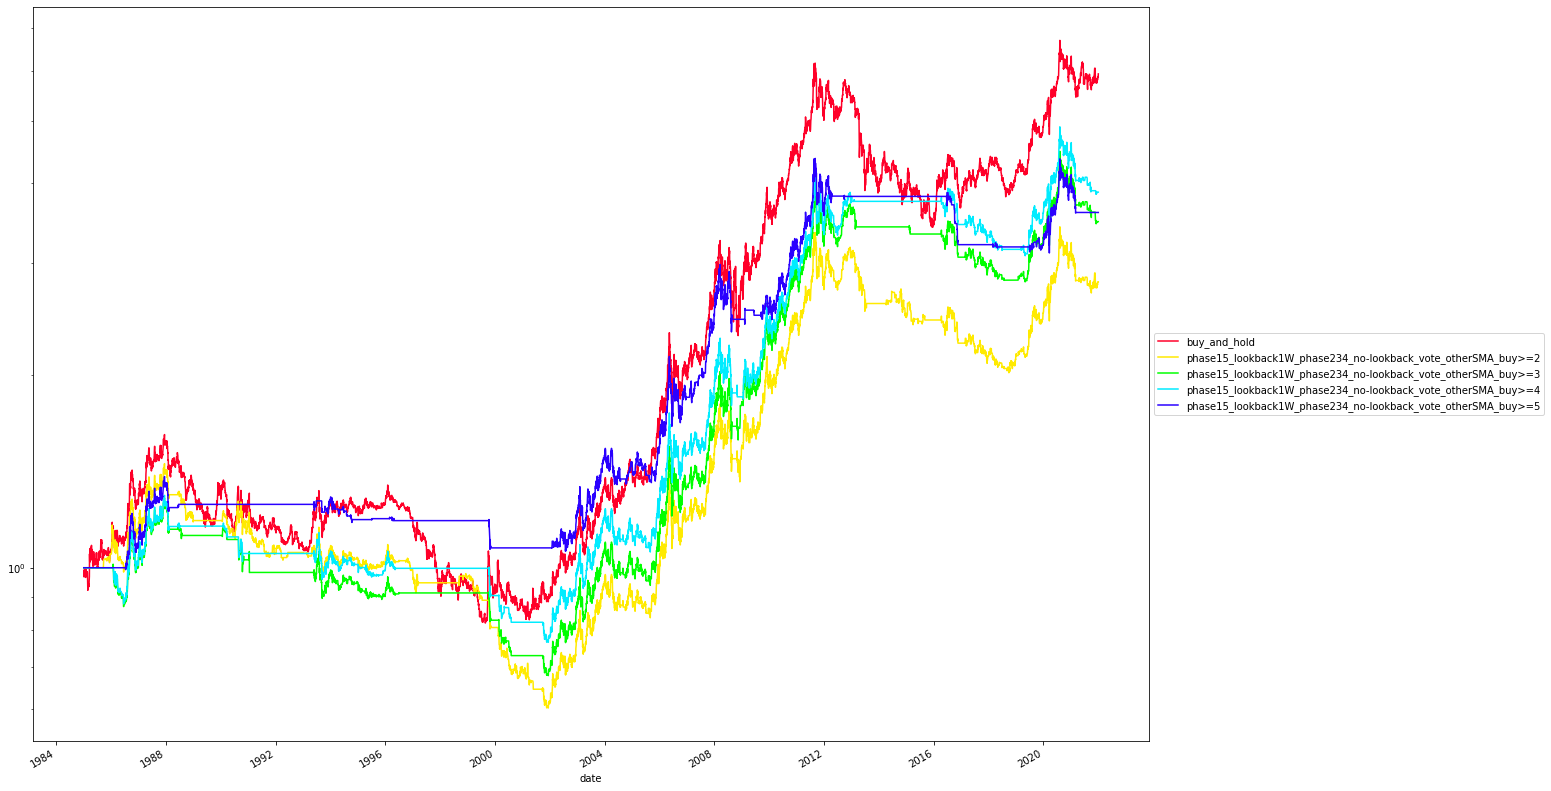

'1988-01-04 00:00:00 to 2000-12-29 00:00:00'

highlight_ratio  \
phase15_lookback1W_phase234_no-lookback_vote_ot...         0.437112   
phase15_lookback1W_phase234_no-lookback_vote_ot...         0.232317   
phase15_lookback1W_phase234_no-lookback_vote_ot...         0.197692   
phase15_lookback1W_phase234_no-lookback_vote_ot...         0.072803   

                                                    flip_ratio      accu  \
phase15_lookback1W_phase234_no-lookback_vote_ot...    0.079929  0.497780   
phase15_lookback1W_phase234_no-lookback_vote_ot...    0.034044  0.506659   
phase15_lookback1W_phase234_no-lookback_vote_ot...    0.028715  0.507547   
phase15_lookback1W_phase234_no-lookback_vote_ot...    0.012729  0.510506   

                                                        prec       mse  
phase15_lookback1W_phase234_no-lookback_vote_ot...  0.483412  1.282901  
phase15_lookback1W_phase234_no-lookback_vote_ot...  0.487898  1.270866  
phase15_lookback1W_phase234_no-lookback_vote_ot...  0.488024  1.262989  
phase15_lookback1W_phase234_no-lookback_vote_ot...  0.487805  1.248974

annual_return  \
buy_and_hold                                            -0.042235   
phase15_lookback1W_phase234_no-lookback_vote_ot...      -0.052082   
phase15_lookback1W_phase234_no-lookback_vote_ot...      -0.039645   
phase15_lookback1W_phase234_no-lookback_vote_ot...      -0.031710   
phase15_lookback1W_phase234_no-lookback_vote_ot...      -0.017164   

                                                    sharpe_ratio  \
buy_and_hold                                           -0.283945   
phase15_lookback1W_phase234_no-lookback_vote_ot...     -0.625134   
phase15_lookback1W_phase234_no-lookback_vote_ot...     -0.591014   
phase15_lookback1W_phase234_no-lookback_vote_ot...     -0.526537   
phase15_lookback1W_phase234_no-lookback_vote_ot...     -0.462920   

                                                    max_drawdown  \
buy_and_hold                                           -0.481481   
phase15_lookback1W_phase234_no-lookback_vote_ot...     -0.528552   
phase15_lookback1W_phase234_no-lookback_vote_ot...     -0.420105   
phase15_lookback1W_phase234_no-lookback_vote_ot...     -0.352454   
phase15_lookback1W_phase234_no-lookback_vote_ot...     -0.213218   

                                                    avg_drawdown  return/avgdd  
buy_and_hold                                           -0.272448     -0.155021  
phase15_lookback1W_phase234_no-lookback_vote_ot...     -0.274091     -0.190017  
phase15_lookback1W_phase234_no-lookback_vote_ot...     -0.231079     -0.171566  
phase15_lookback1W_phase234_no-lookback_vote_ot...     -0.186950     -0.169618  
phase15_lookback1W_phase234_no-lookback_vote_ot...     -0.108359     -0.158396

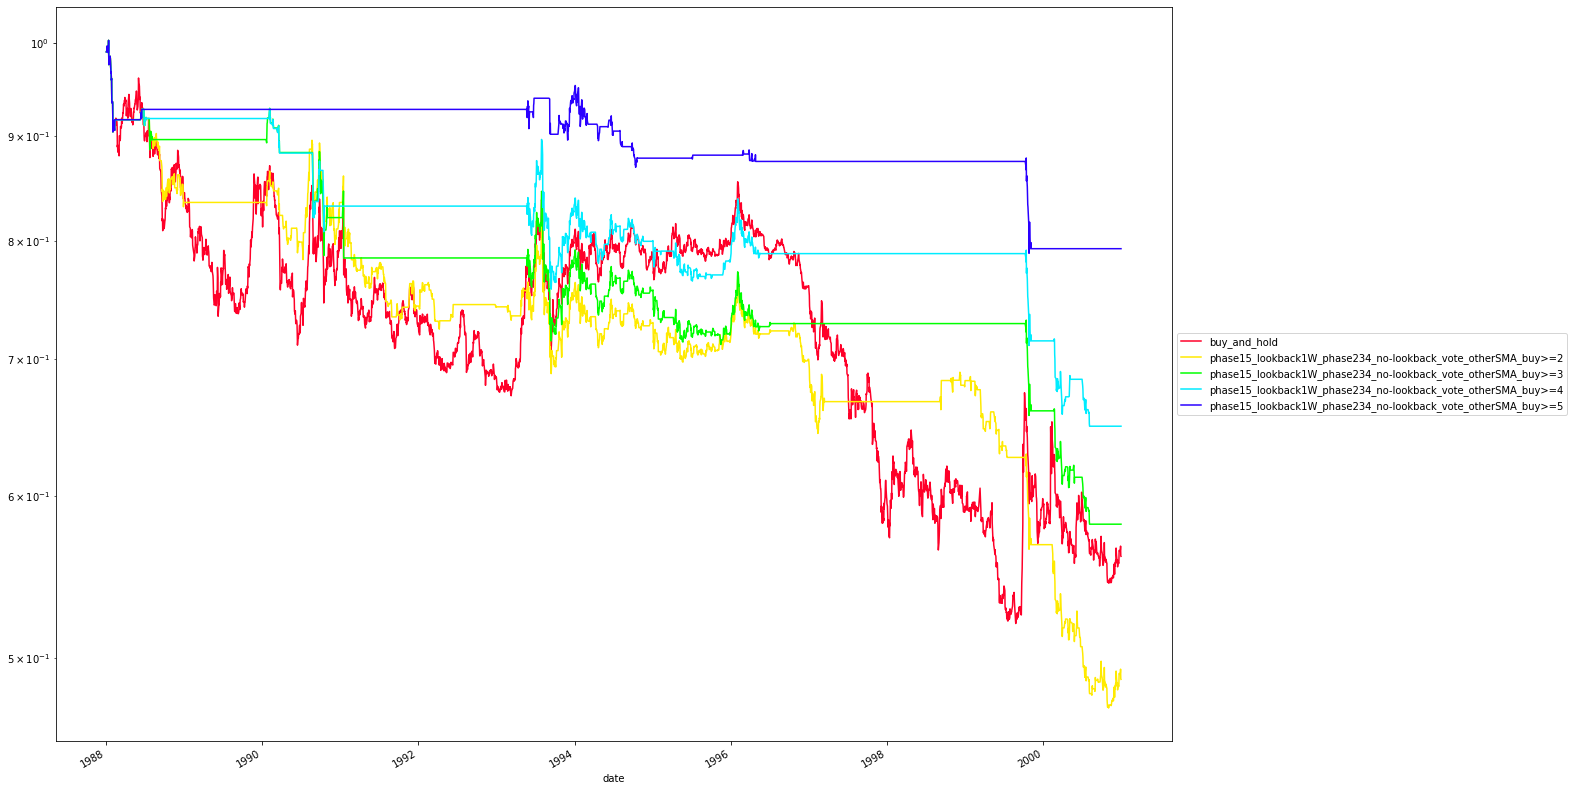

'2001-01-02 00:00:00 to 2005-12-30 00:00:00'

highlight_ratio  \
phase15_lookback1W_phase234_no-lookback_vote_ot...         0.803228   
phase15_lookback1W_phase234_no-lookback_vote_ot...         0.761722   
phase15_lookback1W_phase234_no-lookback_vote_ot...         0.761722   
phase15_lookback1W_phase234_no-lookback_vote_ot...         0.615680   

                                                    flip_ratio      accu  \
phase15_lookback1W_phase234_no-lookback_vote_ot...    0.050000  0.504996   
phase15_lookback1W_phase234_no-lookback_vote_ot...    0.037692  0.511145   
phase15_lookback1W_phase234_no-lookback_vote_ot...    0.037692  0.511145   
phase15_lookback1W_phase234_no-lookback_vote_ot...    0.049231  0.500384   

                                                        prec       mse  
phase15_lookback1W_phase234_no-lookback_vote_ot...  0.530144  1.243537  
phase15_lookback1W_phase234_no-lookback_vote_ot...  0.535822  1.232552  
phase15_lookback1W_phase234_no-lookback_vote_ot...  0.535822  1.232552  
phase15_lookback1W_phase234_no-lookback_vote_ot...  0.535581  1.244607

annual_return  \
buy_and_hold                                             0.132401   
phase15_lookback1W_phase234_no-lookback_vote_ot...       0.071998   
phase15_lookback1W_phase234_no-lookback_vote_ot...       0.085896   
phase15_lookback1W_phase234_no-lookback_vote_ot...       0.085896   
phase15_lookback1W_phase234_no-lookback_vote_ot...       0.072385   

                                                    sharpe_ratio  \
buy_and_hold                                            0.936292   
phase15_lookback1W_phase234_no-lookback_vote_ot...      0.604477   
phase15_lookback1W_phase234_no-lookback_vote_ot...      0.716800   
phase15_lookback1W_phase234_no-lookback_vote_ot...      0.716800   
phase15_lookback1W_phase234_no-lookback_vote_ot...      0.661510   

                                                    max_drawdown  \
buy_and_hold                                           -0.154450   
phase15_lookback1W_phase234_no-lookback_vote_ot...     -0.148948   
phase15_lookback1W_phase234_no-lookback_vote_ot...     -0.146126   
phase15_lookback1W_phase234_no-lookback_vote_ot...     -0.146126   
phase15_lookback1W_phase234_no-lookback_vote_ot...     -0.146126   

                                                    avg_drawdown  return/avgdd  
buy_and_hold                                           -0.042569      3.110238  
phase15_lookback1W_phase234_no-lookback_vote_ot...     -0.066850      1.077010  
phase15_lookback1W_phase234_no-lookback_vote_ot...     -0.050200      1.711063  
phase15_lookback1W_phase234_no-lookback_vote_ot...     -0.050200      1.711063  
phase15_lookback1W_phase234_no-lookback_vote_ot...     -0.042598      1.699255

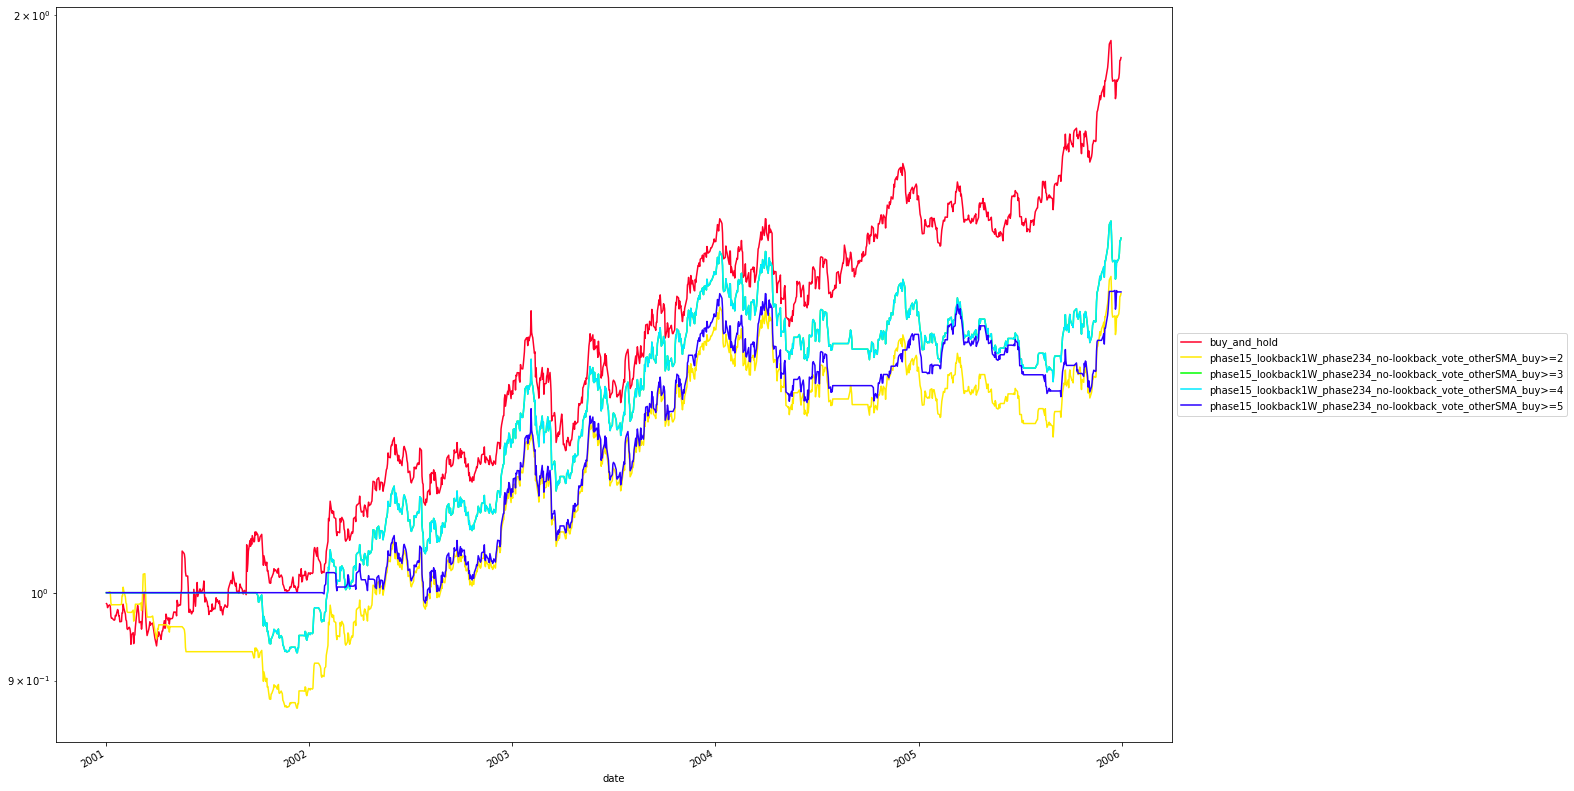

'2006-01-03 00:00:00 to 2008-12-31 00:00:00'

highlight_ratio  \
phase15_lookback1W_phase234_no-lookback_vote_ot...         0.860435   
phase15_lookback1W_phase234_no-lookback_vote_ot...         0.847631   
phase15_lookback1W_phase234_no-lookback_vote_ot...         0.830986   
phase15_lookback1W_phase234_no-lookback_vote_ot...         0.722151   

                                                    flip_ratio      accu  \
phase15_lookback1W_phase234_no-lookback_vote_ot...    0.030769  0.519846   
phase15_lookback1W_phase234_no-lookback_vote_ot...    0.030769  0.522407   
phase15_lookback1W_phase234_no-lookback_vote_ot...    0.024359  0.516005   
phase15_lookback1W_phase234_no-lookback_vote_ot...    0.034615  0.524968   

                                                        prec       mse  
phase15_lookback1W_phase234_no-lookback_vote_ot...  0.529762  1.217749  
phase15_lookback1W_phase234_no-lookback_vote_ot...  0.531722  1.211563  
phase15_lookback1W_phase234_no-lookback_vote_ot...  0.528505  1.228776  
phase15_lookback1W_phase234_no-lookback_vote_ot...  0.539007  1.216953

annual_return  \
buy_and_hold                                             0.186867   
phase15_lookback1W_phase234_no-lookback_vote_ot...       0.155605   
phase15_lookback1W_phase234_no-lookback_vote_ot...       0.170505   
phase15_lookback1W_phase234_no-lookback_vote_ot...       0.133070   
phase15_lookback1W_phase234_no-lookback_vote_ot...       0.161192   

                                                    sharpe_ratio  \
buy_and_hold                                            0.824008   
phase15_lookback1W_phase234_no-lookback_vote_ot...      0.808205   
phase15_lookback1W_phase234_no-lookback_vote_ot...      0.883967   
phase15_lookback1W_phase234_no-lookback_vote_ot...      0.733378   
phase15_lookback1W_phase234_no-lookback_vote_ot...      0.887650   

                                                    max_drawdown  \
buy_and_hold                                           -0.290117   
phase15_lookback1W_phase234_no-lookback_vote_ot...     -0.244881   
phase15_lookback1W_phase234_no-lookback_vote_ot...     -0.222369   
phase15_lookback1W_phase234_no-lookback_vote_ot...     -0.222369   
phase15_lookback1W_phase234_no-lookback_vote_ot...     -0.222369   

                                                    avg_drawdown  return/avgdd  
buy_and_hold                                           -0.090528      2.064197  
phase15_lookback1W_phase234_no-lookback_vote_ot...     -0.096989      1.604348  
phase15_lookback1W_phase234_no-lookback_vote_ot...     -0.095390      1.787448  
phase15_lookback1W_phase234_no-lookback_vote_ot...     -0.097086      1.370643  
phase15_lookback1W_phase234_no-lookback_vote_ot...     -0.091009      1.771171

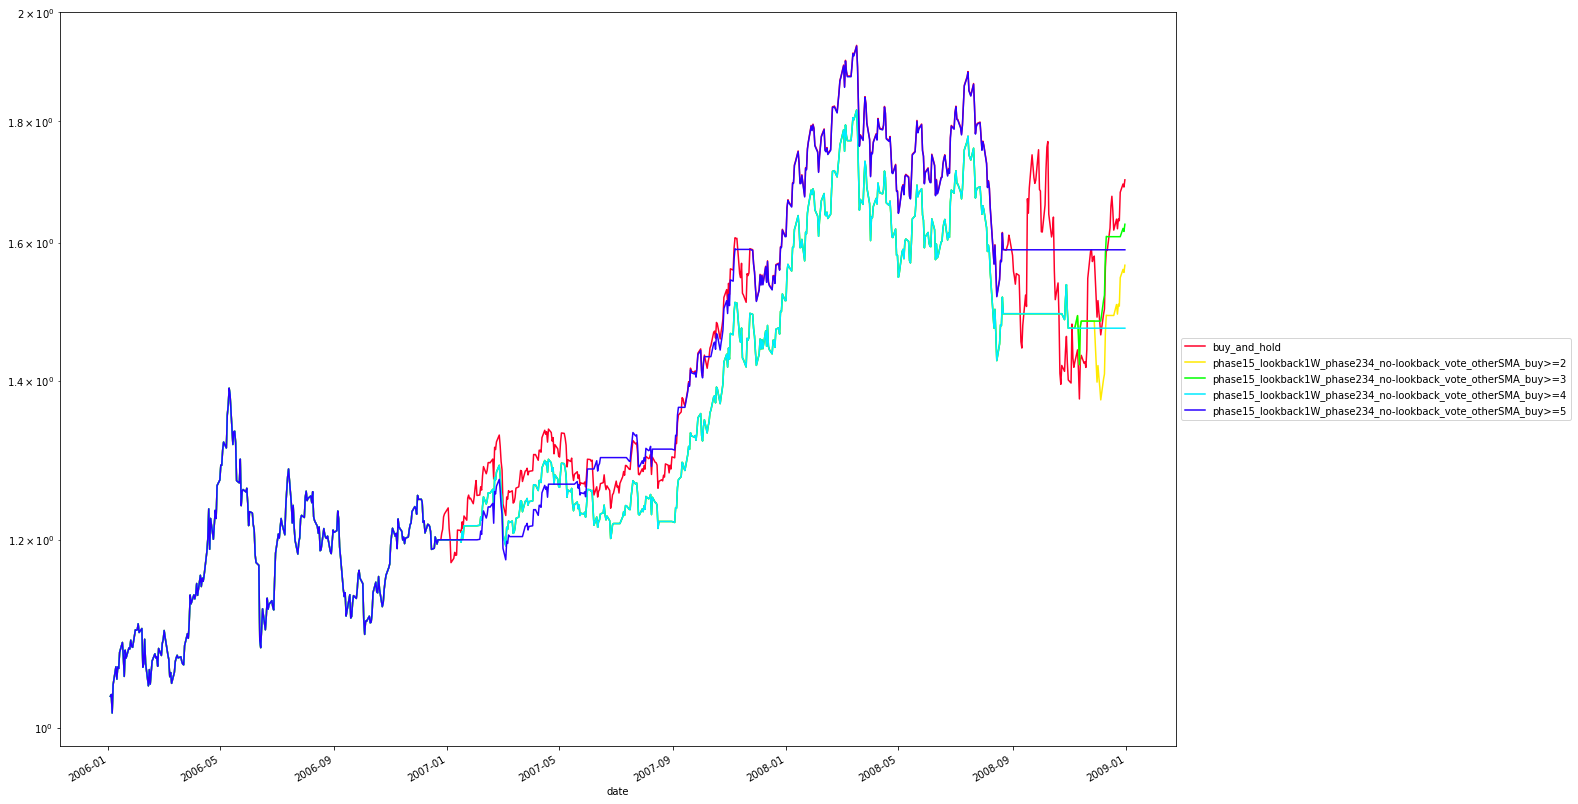

'2009-01-01 00:00:00 to 2011-12-30 00:00:00'

highlight_ratio  \
phase15_lookback1W_phase234_no-lookback_vote_ot...         0.947570   
phase15_lookback1W_phase234_no-lookback_vote_ot...         0.947570   
phase15_lookback1W_phase234_no-lookback_vote_ot...         0.938619   
phase15_lookback1W_phase234_no-lookback_vote_ot...         0.734015   

                                                    flip_ratio      accu  \
phase15_lookback1W_phase234_no-lookback_vote_ot...    0.017926  0.554987   
phase15_lookback1W_phase234_no-lookback_vote_ot...    0.017926  0.554987   
phase15_lookback1W_phase234_no-lookback_vote_ot...    0.019206  0.553708   
phase15_lookback1W_phase234_no-lookback_vote_ot...    0.021767  0.523018   

                                                        prec       mse  
phase15_lookback1W_phase234_no-lookback_vote_ot...  0.558704  1.186376  
phase15_lookback1W_phase234_no-lookback_vote_ot...  0.558704  1.186376  
phase15_lookback1W_phase234_no-lookback_vote_ot...  0.558583  1.181754  
phase15_lookback1W_phase234_no-lookback_vote_ot...  0.554007  1.230054

annual_return  \
buy_and_hold                                             0.203590   
phase15_lookback1W_phase234_no-lookback_vote_ot...       0.203134   
phase15_lookback1W_phase234_no-lookback_vote_ot...       0.203134   
phase15_lookback1W_phase234_no-lookback_vote_ot...       0.211605   
phase15_lookback1W_phase234_no-lookback_vote_ot...       0.132189   

                                                    sharpe_ratio  \
buy_and_hold                                            1.084884   
phase15_lookback1W_phase234_no-lookback_vote_ot...      1.126683   
phase15_lookback1W_phase234_no-lookback_vote_ot...      1.126683   
phase15_lookback1W_phase234_no-lookback_vote_ot...      1.171001   
phase15_lookback1W_phase234_no-lookback_vote_ot...      0.882924   

                                                    max_drawdown  \
buy_and_hold                                           -0.186157   
phase15_lookback1W_phase234_no-lookback_vote_ot...     -0.186157   
phase15_lookback1W_phase234_no-lookback_vote_ot...     -0.186157   
phase15_lookback1W_phase234_no-lookback_vote_ot...     -0.186157   
phase15_lookback1W_phase234_no-lookback_vote_ot...     -0.186157   

                                                    avg_drawdown  return/avgdd  
buy_and_hold                                           -0.044423      4.583029  
phase15_lookback1W_phase234_no-lookback_vote_ot...     -0.042939      4.730773  
phase15_lookback1W_phase234_no-lookback_vote_ot...     -0.042939      4.730773  
phase15_lookback1W_phase234_no-lookback_vote_ot...     -0.042667      4.959446  
phase15_lookback1W_phase234_no-lookback_vote_ot...     -0.029478      4.484409

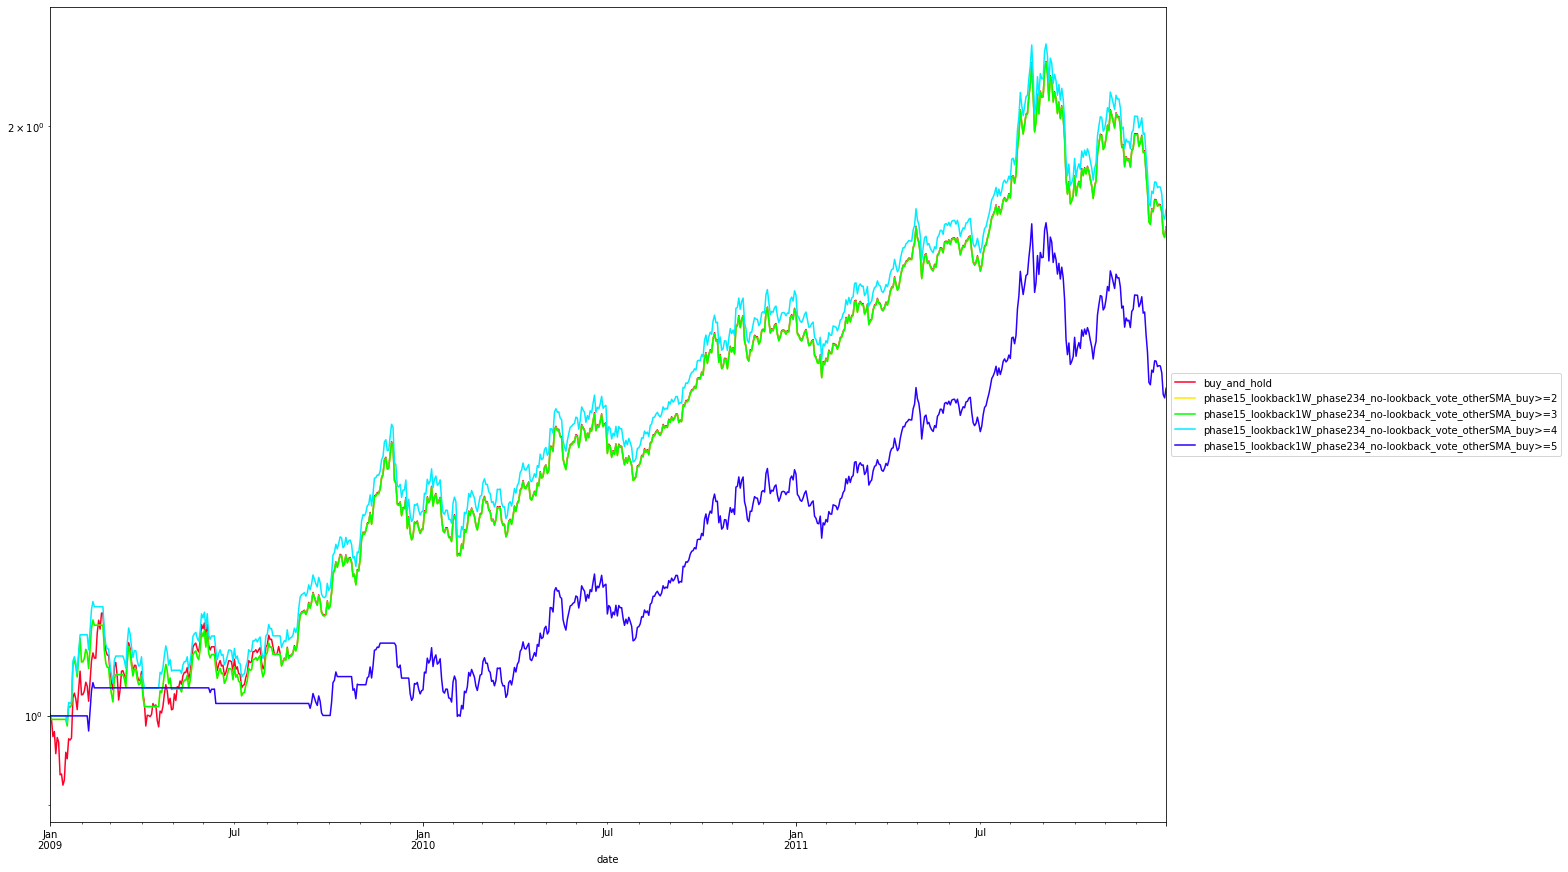

'2012-01-02 00:00:00 to 2015-12-31 00:00:00'

highlight_ratio  \
phase15_lookback1W_phase234_no-lookback_vote_ot...         0.411708   
phase15_lookback1W_phase234_no-lookback_vote_ot...         0.215931   
phase15_lookback1W_phase234_no-lookback_vote_ot...         0.172745   
phase15_lookback1W_phase234_no-lookback_vote_ot...         0.076775   

                                                    flip_ratio      accu  \
phase15_lookback1W_phase234_no-lookback_vote_ot...    0.068204  0.516315   
phase15_lookback1W_phase234_no-lookback_vote_ot...    0.022094  0.539347   
phase15_lookback1W_phase234_no-lookback_vote_ot...    0.022094  0.540307   
phase15_lookback1W_phase234_no-lookback_vote_ot...    0.002882  0.523033   

                                                        prec       mse  
phase15_lookback1W_phase234_no-lookback_vote_ot...  0.501166  1.237582  
phase15_lookback1W_phase234_no-lookback_vote_ot...  0.555556  1.211017  
phase15_lookback1W_phase234_no-lookback_vote_ot...  0.572222  1.196975  
phase15_lookback1W_phase234_no-lookback_vote_ot...  0.550000  1.207138

annual_return  \
buy_and_hold                                            -0.089555   
phase15_lookback1W_phase234_no-lookback_vote_ot...      -0.028808   
phase15_lookback1W_phase234_no-lookback_vote_ot...       0.007884   
phase15_lookback1W_phase234_no-lookback_vote_ot...       0.026690   
phase15_lookback1W_phase234_no-lookback_vote_ot...       0.014063   

                                                    sharpe_ratio  \
buy_and_hold                                           -0.494734   
phase15_lookback1W_phase234_no-lookback_vote_ot...     -0.241638   
phase15_lookback1W_phase234_no-lookback_vote_ot...      0.150698   
phase15_lookback1W_phase234_no-lookback_vote_ot...      0.458212   
phase15_lookback1W_phase234_no-lookback_vote_ot...      0.315631   

                                                    max_drawdown  \
buy_and_hold                                           -0.412616   
phase15_lookback1W_phase234_no-lookback_vote_ot...     -0.243727   
phase15_lookback1W_phase234_no-lookback_vote_ot...     -0.135285   
phase15_lookback1W_phase234_no-lookback_vote_ot...     -0.135285   
phase15_lookback1W_phase234_no-lookback_vote_ot...     -0.092740   

                                                    avg_drawdown  return/avgdd  
buy_and_hold                                           -0.229167     -0.390783  
phase15_lookback1W_phase234_no-lookback_vote_ot...     -0.148624     -0.193833  
phase15_lookback1W_phase234_no-lookback_vote_ot...     -0.077110      0.102240  
phase15_lookback1W_phase234_no-lookback_vote_ot...     -0.037887      0.704456  
phase15_lookback1W_phase234_no-lookback_vote_ot...     -0.069042      0.203685

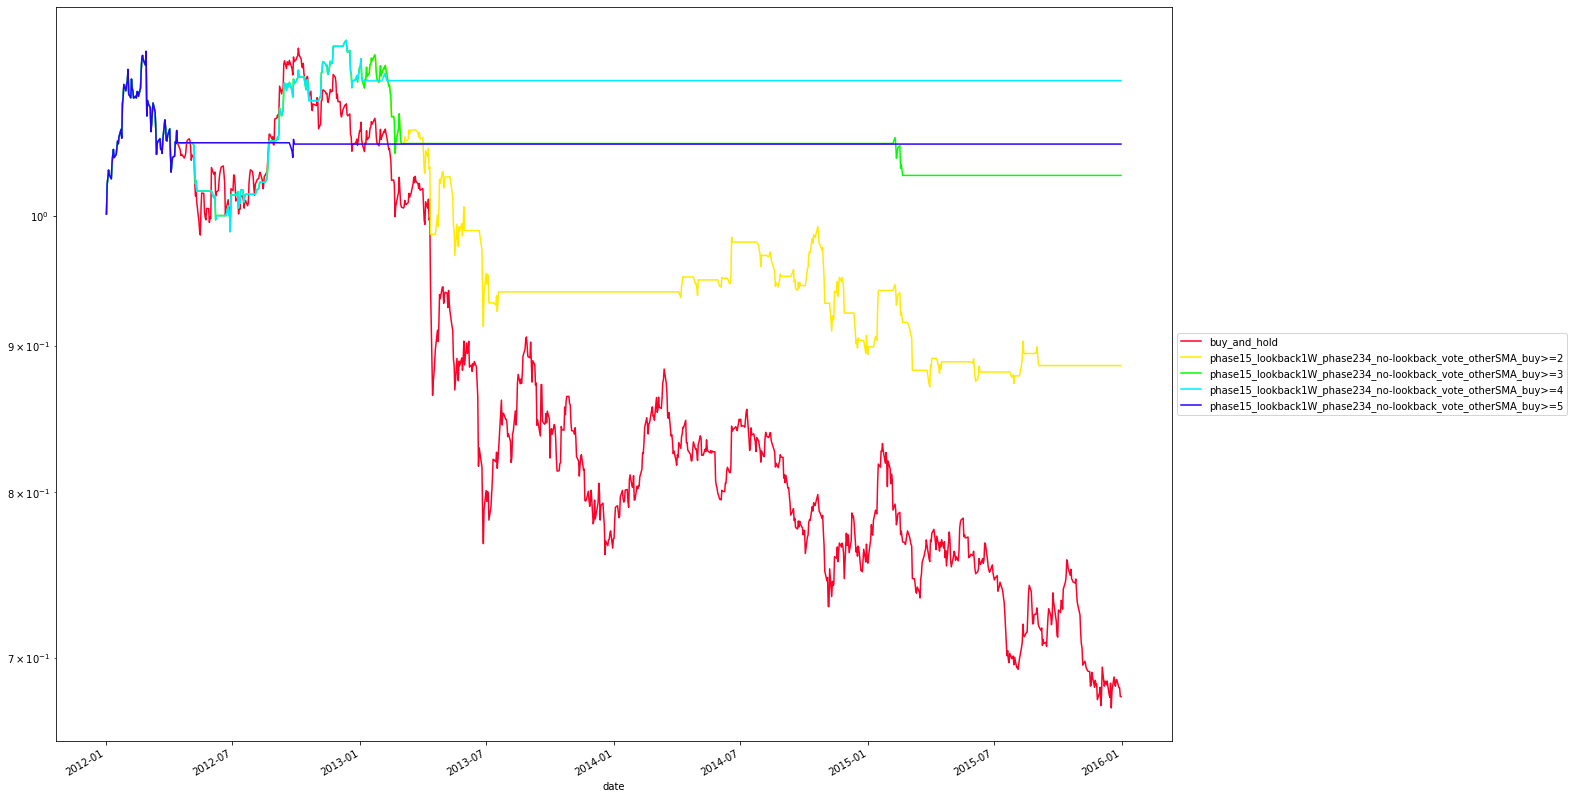

'2016-01-01 00:00:00 to 2021-12-31 00:00:00'

highlight_ratio  \
phase15_lookback1W_phase234_no-lookback_vote_ot...         0.669866   
phase15_lookback1W_phase234_no-lookback_vote_ot...         0.587332   
phase15_lookback1W_phase234_no-lookback_vote_ot...         0.561740   
phase15_lookback1W_phase234_no-lookback_vote_ot...         0.271913   

                                                    flip_ratio      accu  \
phase15_lookback1W_phase234_no-lookback_vote_ot...    0.056338  0.511836   
phase15_lookback1W_phase234_no-lookback_vote_ot...    0.053777  0.504798   
phase15_lookback1W_phase234_no-lookback_vote_ot...    0.046095  0.502239   
phase15_lookback1W_phase234_no-lookback_vote_ot...    0.021767  0.483685   

                                                        prec       mse  
phase15_lookback1W_phase234_no-lookback_vote_ot...  0.535817  1.269771  
phase15_lookback1W_phase234_no-lookback_vote_ot...  0.534858  1.284115  
phase15_lookback1W_phase234_no-lookback_vote_ot...  0.534169  1.285970  
phase15_lookback1W_phase234_no-lookback_vote_ot...  0.536471  1.301356

annual_return  \
buy_and_hold                                             0.091659   
phase15_lookback1W_phase234_no-lookback_vote_ot...       0.022426   
phase15_lookback1W_phase234_no-lookback_vote_ot...       0.007230   
phase15_lookback1W_phase234_no-lookback_vote_ot...       0.005361   
phase15_lookback1W_phase234_no-lookback_vote_ot...      -0.009292   

                                                    sharpe_ratio  \
buy_and_hold                                            0.718013   
phase15_lookback1W_phase234_no-lookback_vote_ot...      0.251002   
phase15_lookback1W_phase234_no-lookback_vote_ot...      0.120502   
phase15_lookback1W_phase234_no-lookback_vote_ot...      0.103733   
phase15_lookback1W_phase234_no-lookback_vote_ot...     -0.054658   

                                                    max_drawdown  \
buy_and_hold                                           -0.185126   
phase15_lookback1W_phase234_no-lookback_vote_ot...     -0.212132   
phase15_lookback1W_phase234_no-lookback_vote_ot...     -0.229774   
phase15_lookback1W_phase234_no-lookback_vote_ot...     -0.215921   
phase15_lookback1W_phase234_no-lookback_vote_ot...     -0.195233   

                                                    avg_drawdown  return/avgdd  
buy_and_hold                                           -0.066784      1.372467  
phase15_lookback1W_phase234_no-lookback_vote_ot...     -0.109362      0.205060  
phase15_lookback1W_phase234_no-lookback_vote_ot...     -0.114985      0.062876  
phase15_lookback1W_phase234_no-lookback_vote_ot...     -0.120714      0.044414  
phase15_lookback1W_phase234_no-lookback_vote_ot...     -0.134956     -0.068850

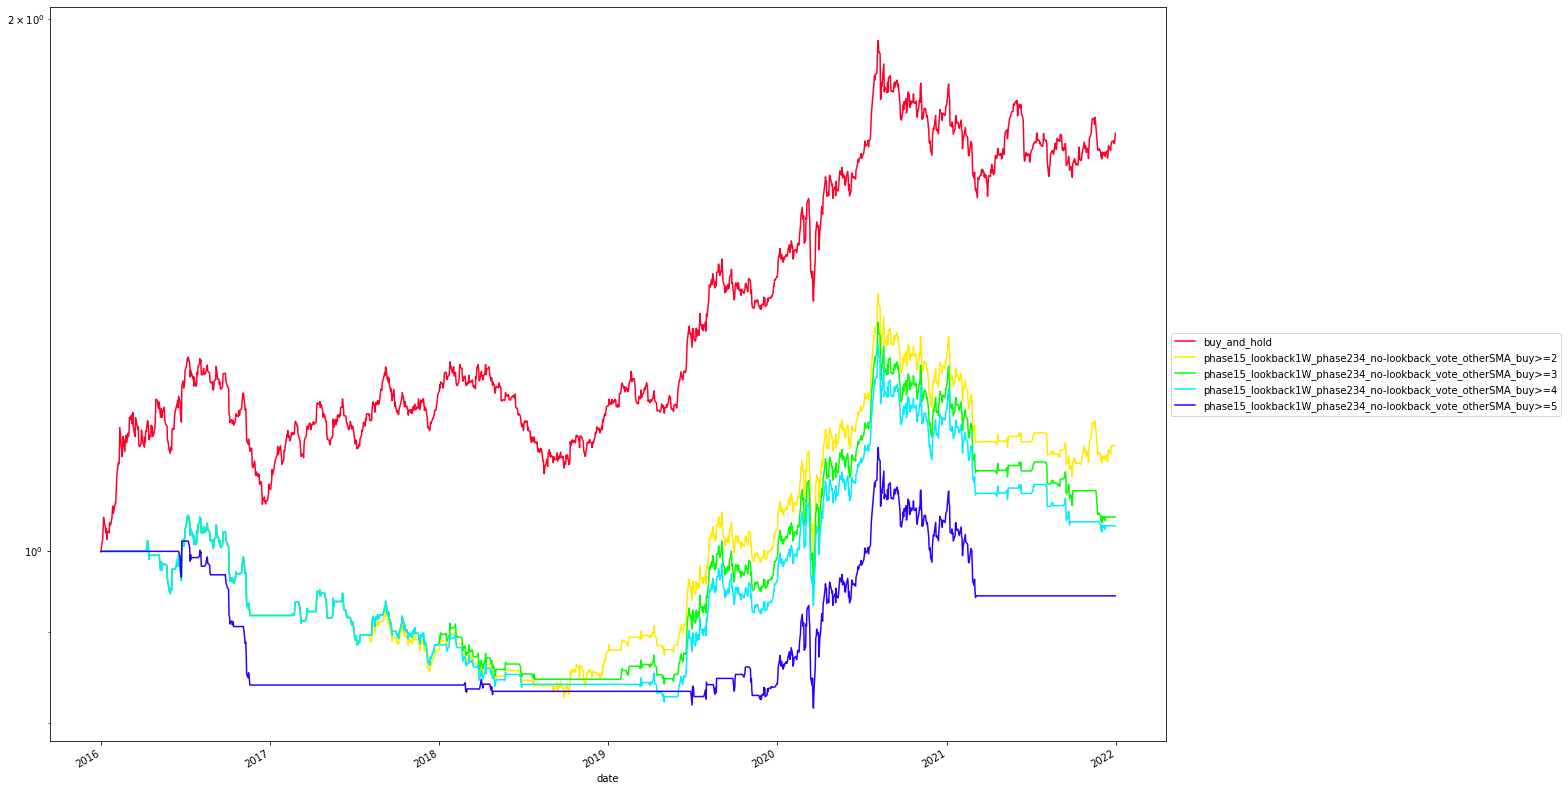

['buy_and_hold',
 'phase15_lookback1W_phase234_no-lookback_vote_otherSMA_buy>=2',
 'phase15_lookback1W_phase234_no-lookback_vote_otherSMA_buy>=3',
 'phase15_lookback1W_phase234_no-lookback_vote_otherSMA_buy>=4',
 'phase15_lookback1W_phase234_no-lookback_vote_otherSMA_buy>=5']

In [46]:
list_tmp = [i for i in ret_sma_cross.columns if ('buy_and_hold' in i) 
            or ('no-lookback_vote_' in i)
           ]
ret_tmp = ret_sma_cross[list_tmp]
strategy_list_sel = print_all_result(ret_tmp)

print_all_result(ret_tmp['1988':'2000'], strategy_list_sel=strategy_list_sel)
print_all_result(ret_tmp['2001':'2005'], strategy_list_sel=strategy_list_sel)
print_all_result(ret_tmp['2006':'2008'], strategy_list_sel=strategy_list_sel)
print_all_result(ret_tmp['2009':'2011'], strategy_list_sel=strategy_list_sel)
print_all_result(ret_tmp['2012':'2015'], strategy_list_sel=strategy_list_sel)
print_all_result(ret_tmp['2016':'2021'], strategy_list_sel=strategy_list_sel)

In [29]:
# true_yret_roll_vote_pred
# true_yret_up

acc = pd.Series(index=true_yret_roll_vote_pred.columns)
for col in true_yret_roll_vote_pred.columns:
    acc[col] = accuracy_score(true_yret_up[true_yret_roll_vote_pred.index], true_yret_roll_vote_pred[col])
acc

NameError: name 'true_yret_up' is not defined

In [ ]:
true_ret_roll_vote_proba = pd.DataFrame()
lookbacks = [1, 2, 3, 5, 8, 10, 15]
for lookback in lookbacks:
    true_yret_rollN = true_up.astype(int).rolling(lookback*252).mean()
    true_yret_rollN.name = 'lookback{}Y_vote'.format(lookback)
    # print("================================\n", true_yret_rollN)
    true_ret_roll_vote_proba = pd.concat([true_ret_roll_vote_proba, true_yret_rollN], axis=1)

true_ret_roll_vote_proba = true_ret_roll_vote_proba.dropna()
true_ret_roll_vote_proba

In [ ]:
total_return = lambda x: (1+x).prod()-1
true_ret.name = 'true_ret'

lookbacks = [1, 2, 3, 5, 8, 10, 15]
true_yret_roll_ret = pd.DataFrame()
for lookback in lookbacks:
    true_yret_rollN = true_ret.rolling(lookback*252).apply(total_return)
    true_yret_rollN.name = 'lookback{}Y_ret'.format(lookback)
    true_yret_roll_ret = pd.concat([true_yret_roll_ret, true_yret_rollN], axis=1)
true_yret_roll_ret = true_yret_roll_ret.dropna()
true_yret_roll_ret_pred = (true_yret_roll_ret > 0).astype(int).shift().dropna()
# true_yret_roll_ret_pred.index = pd.to_datetime(['{}-01-01'.format(i) for i in true_yret_roll_ret_pred.index])
true_yret_roll_ret_pred

In [ ]:
price[true_yret_roll_ret.index].plot()
plt.show()

for col in true_yret_roll_ret.columns:
    tt = true_yret_roll_ret[col]
    tt.plot(title=col)
    plt.show()

In [ ]:
total_return = lambda x: (1+x).prod()-1
true_yret.name = 'true'

lookbacks = [1, 2, 3, 5, 8, 10, 15]
true_yret_roll_ret = pd.DataFrame()
for lookback in lookbacks:
    true_yret_rollN = true_yret.rolling(lookback).apply(total_return)
    true_yret_rollN.name = 'lookback{}Y_ret'.format(lookback)
    true_yret_roll_ret = pd.concat([true_yret_roll_ret, true_yret_rollN], axis=1)
true_yret_roll_ret = true_yret_roll_ret.dropna()
true_yret_roll_ret_pred = (true_yret_roll_ret > 0).astype(int).shift().dropna()
true_yret_roll_ret_pred.index = pd.to_datetime(['{}-01-01'.format(i) for i in true_yret_roll_ret_pred.index])
true_yret_roll_ret_pred

In [ ]:
preds = pd.DataFrame(1, columns=['buy_and_hold'], index=true_ret.index)
preds = pd.concat([preds, true_yret_roll_ret_pred, true_yret_roll_vote_pred], axis=1)
preds = preds.fillna(method='ffill')
preds = preds.loc[true_ret.index, :]
preds = preds['1994': end]
preds.shape

In [ ]:
ret_sma_cross = preds.multiply(true_ret[preds.index], 0)
ret_sma_cross.shape

In [ ]:
strategy_list_sel = print_all_result(ret_sma_cross)